In [1]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from skipper_image_analysis.utils import (
    plot_ccd_image, correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit
from scipy.stats import chi2
# from scipy.signal import peak_prominences, peak_widths


def intensidad_func(tph, tau, Pc):
    npump = 40000
    return npump*Pc*(np.exp(-tph/tau) - np.exp(-2*tph/tau))


def gaussiana(x, amplitud, mu, sigma):
    return amplitud * np.exp(-(x - mu)**2/(2*sigma**2))


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

# Las carpetas que siguen tienen el sequencer viejo en donde los voltajes eran bajos
# y se veían un número absurdo de trampas
#CARPETAS_POR_TEMP: dict[str, list[str]] = {
#    126: ["skipper_data/TRAPS/09NOV2023/",],
#    127: ["skipper_data/TRAPS/16NOV2023_127K/","skipper_data/TRAPS/18NOV2023_127K/"],
#    140: ["skipper_data/TRAPS/10NOV2023_140K/", "skipper_data/TRAPS/16NOV2023_140K/"],
#    150: ["skipper_data/TRAPS/11NOV2023_150K/", "skipper_data/TRAPS/11NOV2023_150K_bis/", "skipper_data/TRAPS/16NOV2023_150K"],
    
#}

# Las carpetas que siguen tienen el sequencer nuevo en donde los voltajes son más altos
CARPETAS_POR_TEMP: dict[str, list[str]] = {
    127: ["skipper_data/TRAPS/19NOV2023_127K/", "skipper_data/TRAPS/20NOV2023_127K/",],
    135: ["skipper_data/TRAPS/27NOV2023_135K/",],
    140: ["skipper_data/TRAPS/23NOV2023_140K/",],
    145: ["skipper_data/TRAPS/25NOV2023_145K/",],
    150: ["skipper_data/TRAPS/22NOV2023_150K/",],
}
RESULTS_DIR = "skipper_image_analysis/TRAPS_results"
CLOCKS_TO_SEC = 15e6  # Hz

## Exploración parámetros `intensidad_func`

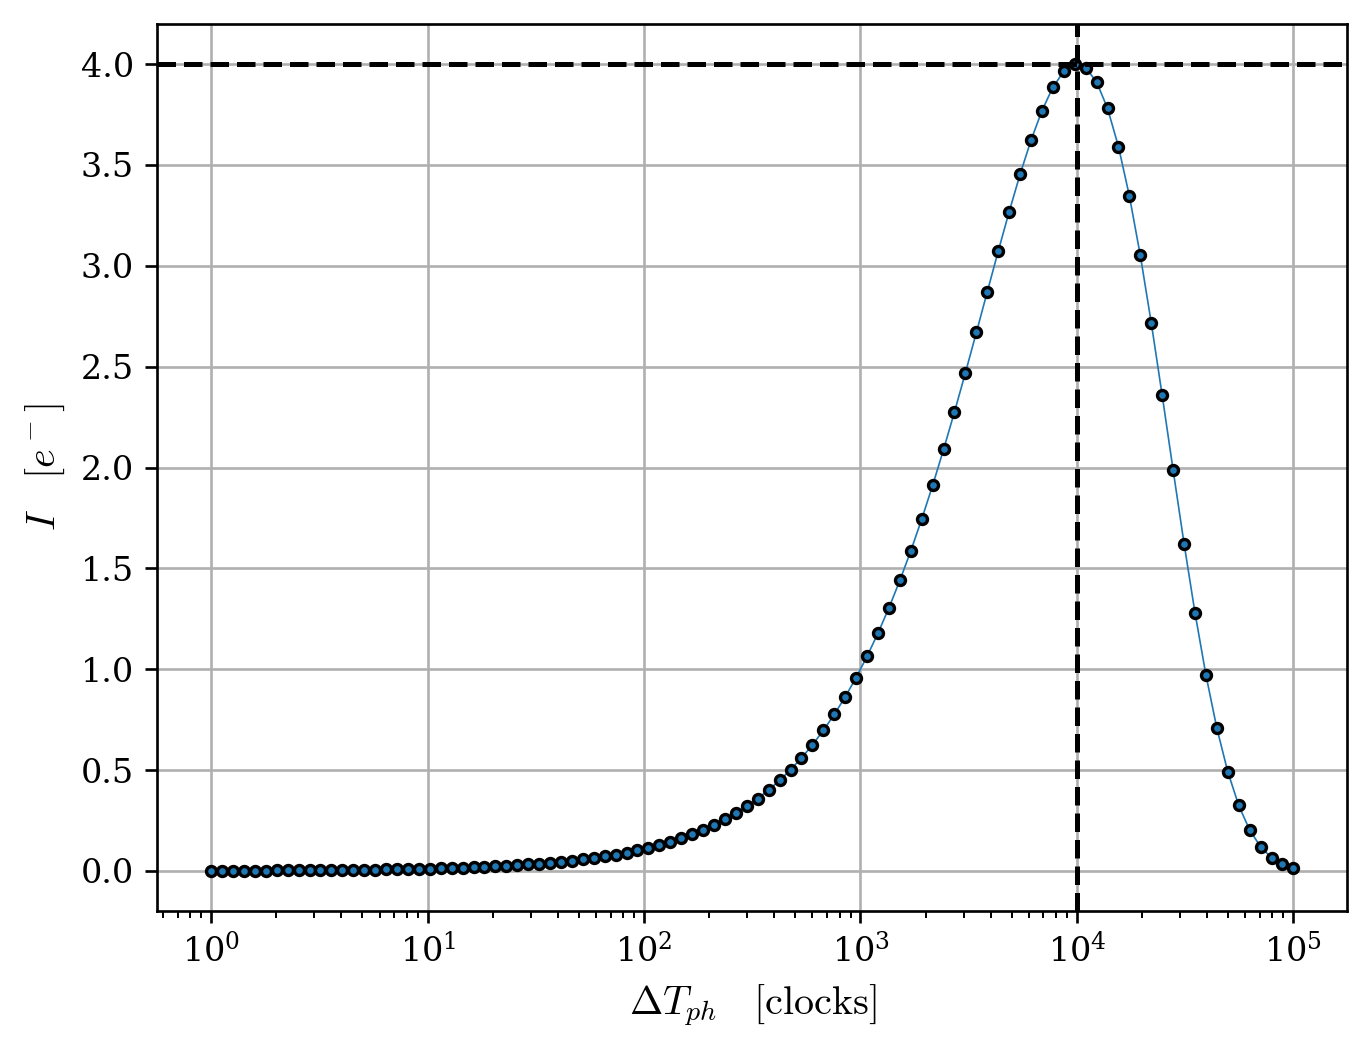

In [2]:
plt.close("all")
%matplotlib inline
dtph_dense = np.geomspace(1, 1e5, 100)
dtph_pico = 1e4
tau = dtph_pico/np.log(2)
val_pico = 4
pc = val_pico*4/40_000

plt.plot(dtph_dense, intensidad_func(dtph_dense, tau, pc), ".-", lw=0.5, mec="k")
plt.axvline(dtph_pico, c="k", ls="--")
plt.axhline(val_pico, c="k", ls="--")
plt.grid()
plt.xscale("log")
plt.xlabel(r"$\Delta T_{ph}\quad [\mathrm{clocks}]$")
plt.ylabel(r"$I\quad [e^-]$")
plt.show()

# Funciones de Carga y Procesamiento

In [3]:
def prepare_frame(
    skipper_image: fits.hdu.hdulist.HDUList,
    frame_idx: int,
    remove_row_median: bool = True,
) -> ArrayLike:
    global GANANCIA, PRESCAN_PIX
    r_overscan, c_overscan = get_rowcol_ovserscan(skipper_image)
    # Extract Read Error from Column Overscan
    overscan_frame = (
        skipper_image[frame_idx].data[:, -c_overscan:]
        / GANANCIA[frame_idx]
    )  # e⁻
    # error = overscan_frame.std()  # e⁻
    # Fit Gaussian to Column Overscan Distribution
    charge_frec, charge_bins = np.histogram(
        overscan_frame.flatten(),
        bins=np.linspace(
            overscan_frame.min(),
            np.min([overscan_frame.max(), -overscan_frame.min()]),
            500
        ),
        density=True,
    )
    try:
        popt, _ = curve_fit(
            gaussiana,
            charge_bins[:-1],
            charge_frec,
            p0=[1/np.sqrt(2*np.pi*4), 0, overscan_frame.std()],
        )
        error = np.abs(popt[2])  # e⁻
        # plt.plot(charge_bins[:-1], charge_frec, ".")
        # plt.plot(charge_bins[:-1], gaussiana(charge_bins[:-1], *popt))
        # plt.show()
    except RuntimeError:
        error = overscan_frame.std()
        # plt.plot(charge_bins[:-1], charge_frec, ".")
        # plt.plot(charge_bins[:-1], gaussiana(charge_bins[:-1], 1/np.sqrt(2*np.pi*4), 0, error))
        # plt.show()
    
    
    # Correct Baseline from Overscan in Rows and Columns
    skipper_image = correct_overscan(skipper_image)  # A.D.U.
    frame = skipper_image[frame_idx].data  # A.D.U.
    frame = frame[1:-r_overscan, PRESCAN_PIX:-c_overscan]  # A.D.U.
    if remove_row_median:
        # Remove the median of each row so that the median of the frame is zero
        frame = frame - np.median(frame, axis=1, keepdims=True)  # A.D.U.
    return frame/GANANCIA[frame_idx], error # e⁻


def filtro_dipolos(
    frame: ArrayLike,
    threshold: float = 5e5,  # e⁻
    corte_simetria: float = 20,  # %
) -> tuple[list, list, ArrayLike]:  # ACTUALIZAR EN CÓDIGO!
    """Busca dipolos en un frame de la CCD. Para ello, se calcula el producto entre \
cada pixel y su vecino inferior. Si el producto es menor que un umbral negativo, se \
considera que hay un dipolo. Luego, se revisa que el dipolo sea simétrico, es decir, \
que los valores de los pixeles sean similares en magnitud. Si el dipolo es simétrico, \
se agrega a la lista de dipolos encontrados. Finalmente, se devuelve una lista con \
las coordenadas de los dipolos, una máscara con los dipolos encontrados y una lista \
con los valores de los dipolos.

    Parameters:
    -----------

        `frame {ArrayLike}`: Frame de la CCD a analizar. Debe estar en unidades de \
electrones.

        `threshold {float, optional}`: Valor umbral en la clasificación de picos. \
Valor por defecto = 500_000.

        `corte_simetria {float, optional}`: Defaults to 20.

    Returns:
    --------

        `{tuple[list, list, ArrayLike]}`:
    """
    prod_arr = frame[:-1] * frame[1:]
    val_trampas = []
    coordenadas_trampas = []
    mascara = np.zeros_like(frame)
    for j, col in enumerate(prod_arr.T):  # Recorro las columnas del frame
        for i, val in enumerate(col):  # Recorro los valores de cada columna
            if val < -threshold:
                # Reviso que no esté en el borde del frame
                if i == 0:
                    i_lleno = np.argmax(frame[i:i+2, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i:i+2, j])
                    i_vacio = i_vacio + i - 1
                elif i == len(col):
                    i_lleno = np.argmax(frame[i-1:i+1, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i-1:i+1, j])
                    i_vacio = i_vacio + i - 1
                else:
                    i_lleno = np.argmax(frame[i-1:i+2, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i-1:i+2, j])
                    i_vacio = i_vacio + i - 1
                if np.abs(i_lleno-i_vacio) == 1:  # Confirmo adyacencia
                    val_1  = frame[i_lleno, j]
                    val_2 = frame[i_vacio, j]
                    diferencia_relativa = np.abs(
                        100
                        * (np.abs(val_1) - np.abs(val_2))
                        / np.max([np.abs(val_1), np.abs(val_2)])
                    )
                    #print(diferencia_relativa)
                    if diferencia_relativa < corte_simetria: #filtro por simetría
                        coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
                        val_trampas.append(np.abs(val_1-val_2)/2)
                        mascara[i_lleno, j] = 1
                        mascara[i_vacio, j] = 1
    return coordenadas_trampas, val_trampas, mascara

In [4]:
def carga_archivos(
    temperatura: int, dir_idx: int, frame_idx: int,
    threshold: float = 5e5, corte_simetria: float = 20
) -> tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]:
    """Carga los archivos de una carpeta de una temperatura y un número de archivo \
específicos. Luego, aplica el filtro de dipolos a cada frame y devuelve las \
coordenadas de los dipolos, los valores de los dipolos, una máscara con los dipolos \
encontrados, el objeto fits con los datos de la CCD en la última imagen procesada y \
un diccionario con los errores de cada frame.

    Parameters:
    -----------

        `temperatura {int}`: Temperatura de la CCD en Kelvin durante la toma de datos.

        `dir_idx {int}`: Índice de la carpeta con los archivos a cargar cuando existe \
más de una carpeta por temperatura.

        `frame_idx {int}`: Índice del frame/cuadrante de la CCD a analizar.

        `threshold {float, optional}`: Umbrál en (e⁻)² para la detección de dipolos. \
Valor por defecto = 500_000.

        `corte_simetria {float, optional}`: Porcentaje de la diferencia en simetría \
para el filtro en la detección de dipolos. Valor por defecto = 20.

    Returns:
    --------

        `{tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]}`: Diccionarios\
 con las coordenadas de los dipolos, los valores de los dipolos, una máscara con los \
dipolos encontrados, el objeto fits con los datos de la CCD en la última imagen y un \
diccionario con los errores de cada frame.
    """
    global CARPETAS_POR_TEMP
    # Cargar Archivos desde sus Carpetas por Temperatura
    data_dir = CARPETAS_POR_TEMP[temperatura][dir_idx]
    files_in_dir = os.listdir(data_dir)
    valid_formats = ["fits",]
    files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
    frames_dict = dict()
    error_dict = dict()
    coords_dict = dict()
    vals_dict = dict()
    mascara_dipolos = dict()
    for file in tqdm(files_in_dir, desc="Procesando Archivos"):
        dtph = int(file.rsplit("_")[5][4:])
        if dtph in coords_dict:
            continue
        test_image = fits.open(f'{data_dir}/{file}')
        frames_dict[dtph], error_dict[dtph] = prepare_frame(test_image, frame_idx)  # e⁻
        coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
            frames_dict[dtph], threshold, corte_simetria
        )
    return coords_dict, frames_dict, vals_dict, mascara_dipolos, test_image, error_dict


def identificacion_e_intensidad(coords_dict, frames_dict):
    """Identifica trampas en todos los dtph y busca la intensidad
    de cada trampa en todos los dtph"""
    coords_medidas = set()
    trampas_halladas = []
    intensidad_por_trampa = []
    dtph_vals = list(coords_dict.keys())
    dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
    for dtph in tqdm(
        dtph_vals[::-1],
        desc="Recorriendo dTph",
        total=len(dtph_vals),
    ):
        coordenadas_trampas = coords_dict[dtph]
        for coords in coordenadas_trampas:
            if coords in coords_medidas:
                  # Creo que coords_medidas terminó siendo redundante y este if podría
                  # chequear directamente en trampas_halladas
                continue
            trampas_halladas.append(coords)
            intensidades_trampa = []
            for dtph_frames in dtph_vals:
                frame = frames_dict[dtph_frames]
                intensidades_trampa.append(np.abs(frame[coords[0]]-frame[coords[1]])/2)
            intensidad_por_trampa.append(intensidades_trampa)
            coords_medidas.add(coords)
    return trampas_halladas, intensidad_por_trampa, dtph_vals


def grafico_trampas_por_carpeta(frame_idx, test_image, trampas_halladas) -> None: 
    fig, ax = plt.subplots(1, 1)
    fig.set_label(f"Frame {frame_idx}")
    test_frame, error = prepare_frame(test_image, frame_idx)  # e⁻
    mappable = ax.imshow(test_frame, cmap="viridis", origin="lower", vmin=-2e3, vmax=2e3, interpolation="none", )
    x_traps = []
    y_traps = []
    for coords in trampas_halladas:
        x_traps.append(coords[0][0])
        x_traps.append(coords[1][0])
        y_traps.append(coords[0][1])
        y_traps.append(coords[1][1])
    plt.plot(y_traps, x_traps, 'sr', ms=2, alpha=0.5)
    ax.set_xlabel("Columnas")
    ax.set_ylabel("Filas")
    #ax.set_xlim(100, 150)
    #ax.set_ylim(100, 150)
    plt.colorbar(mappable, label=r"$e^-$", ax=ax, extend="both", location="left", pad=0.2)
    return None
    



In [5]:
# Cargamos desde archivos:
try:
    with open(f"{RESULTS_DIR}/trampas_unicas.pkl", "rb") as f:
        trampas_unicas = pickle.load(f)
    with open(f"{RESULTS_DIR}/temp_por_fila.pkl", "rb") as f:
        temp_por_fila = pickle.load(f)
    tau_vals_dict = np.load(f"{RESULTS_DIR}/tau_vals.npz", )
    todos_tau_vals = tau_vals_dict["todos_tau_vals"]
    todos_tau_errs = tau_vals_dict["todos_tau_errs"]
    print("Resultados cargados desde skipper_image_analysis/TRAPS_results")
except FileNotFoundError:
    print("No encontré archivos.")

Resultados cargados desde skipper_image_analysis/TRAPS_results


## Análisis de la Intensidad de las Trampas (Modelo)

In [54]:
plt.close('all')
%matplotlib widget
plot_example = False
temperatura = 140
trampas = [[], []]  # trampas[frame_idx][dir_idx][coord_idx]
intensidad = [[], []]  # intensidad[frame_idx][dir_idx][coord_idx][dtph_idx]
dtph = [[], []]  # dtph[frame_idx][dir_idx][coord_idx][dtph_idx]
error = [[], []]  # error[frame_idx][dir_idx][dtph_idx]
for frame_idx in [0, 1]:
    for dir_idx in range(len(CARPETAS_POR_TEMP[temperatura])):
        coords_dict, frames_dict, vals_dict, mascara_dipolos, test_image, err = carga_archivos(
            temperatura, dir_idx, frame_idx
        )
        trampas_halladas, intensidad_por_trampa, dtph_vals = identificacion_e_intensidad(
            coords_dict, frames_dict
        )
        #print(trampas_halladas[4])
        #print(intensidad_por_trampa[4])
        if plot_example:
            grafico_trampas_por_carpeta(frame_idx, test_image, trampas_halladas)
            plot_example = False
        trampas[frame_idx].append(trampas_halladas)
        intensidad[frame_idx].append(intensidad_por_trampa)
        dtph[frame_idx].append(dtph_vals)
        error[frame_idx].append(err)


Procesando Archivos:   0%|          | 0/20 [00:00<?, ?it/s]

Recorriendo dTph:   0%|          | 0/20 [00:00<?, ?it/s]

Procesando Archivos:   0%|          | 0/20 [00:00<?, ?it/s]

Recorriendo dTph:   0%|          | 0/20 [00:00<?, ?it/s]

In [65]:
# dir_idx = 0
# frame_idx = 1
# i = 4
traps_to_plot = [
    # (1, 0, 3), (1, 0, 9), (1, 0, 10), (1, 0, 11), (0, 1, 10), (0, 1, 14), (0, 1, 19), (1, 1, 20) # Fixed: T=127K
    # (0, 1, 8), (0, 1, 15), (0, 1, 20), (0, 1, 28),  # Fixed: T=135K
    # (0, 0, 4),  # Fixed: T=140K
    (0, 1, 6), (0, 1, 7), (0, 1, 9)
    # (0, 0, 20),  # Fixed: T=150K
    # (dir_idx, frame_idx, 0+3*i), (dir_idx, frame_idx, 1+3*i), (dir_idx, frame_idx, 2+3*i),  # Testing
]

p = 0	p = 5e-258	p = 0.9	p = 0.1	p = 0.9	p = 5e-118	p = 2e-304	p = 7e-35	p = 5e-35	p = 1e-07	p = 2e-26	p = 0.01	p = 1	p = 0.0003	p = 5e-22	p = 1e-10	p = 6e-22	p = 1e-22	p = 5e-195	p = 8e-68	p = 0	p = 2e-135	p = 1e-308	p = 8e-196	p = 2e-301	p = 1e-42	p = 7e-64	p = 9e-19	p = 0.003	p = 3e-40	p = 0.006	p = 2e-08	p = 4e-08	p = 2e-31	p = 0.0001	p = 0.06	p = 1	

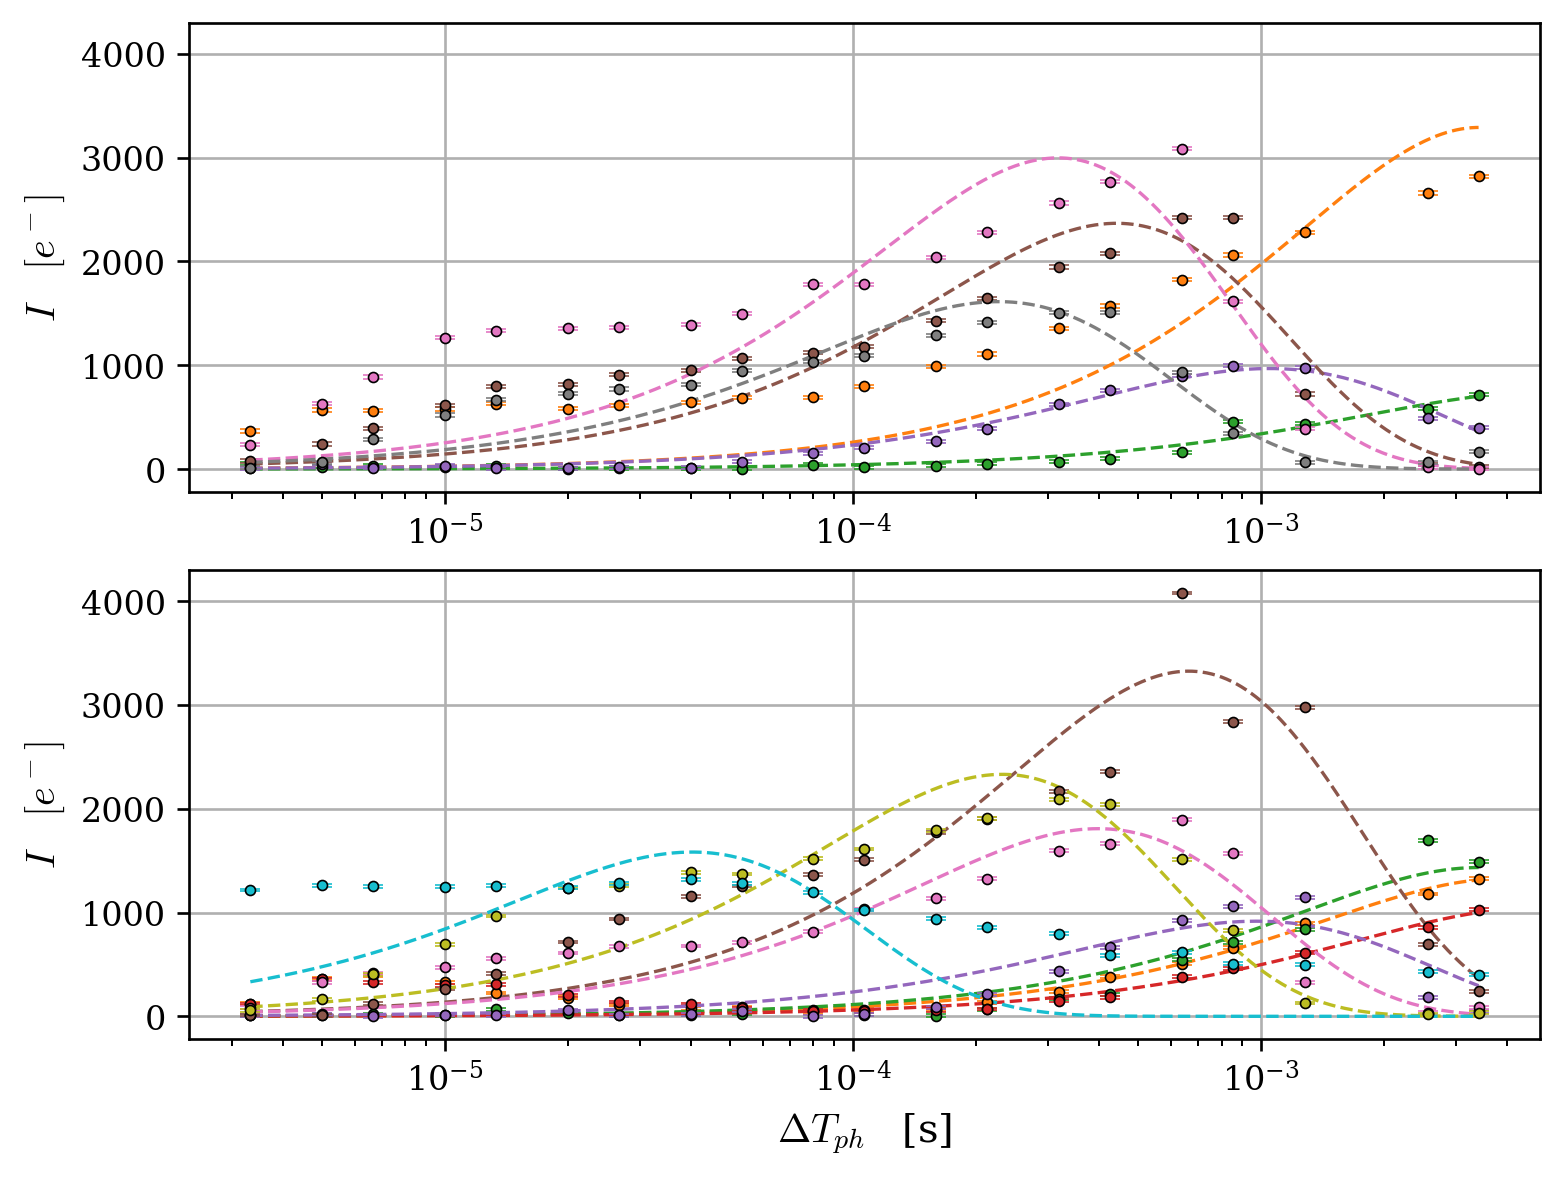

In [69]:
plt.close("all")
%matplotlib inline
fitted_traps = [[], []]
fitted_tau_vals = [[], []]
fitted_tau_errs = [[], []]
fig, axs = plt.subplots(
    2, 1, #len(CARPETAS_POR_TEMP[temperatura]),  # 2 frames por barrido
    squeeze=False, constrained_layout=True, sharey=True,
)
# fig, ax = plt.subplots(1, 1)
# plot_every = 4

# for frame_idx, ax_row in enumerate(axs):
for frame_idx, ax_row in enumerate(axs):
    ax = ax_row[0]
    for dir_idx, (trampas_halladas, intensidad_por_trampa, err_vals, dtph_vals,) in enumerate(
        zip(trampas[frame_idx], intensidad[frame_idx], error[frame_idx], dtph[frame_idx],)  # ax_row)
    ):
        err_vals = np.array([err_vals[dtph] for dtph in dtph_vals])/np.sqrt(2) * 5
        fitted_traps[frame_idx].append([])
        fitted_tau_vals[frame_idx].append([])
        fitted_tau_errs[frame_idx].append([])
        dtph_dense = np.geomspace(min(dtph_vals), max(dtph_vals), 1000)
        for i, (trampa, intensidades) in enumerate(
            zip(trampas_halladas, intensidad_por_trampa)
        ):
            # Heuristicas para el fit:
            idx_pico = np.argmax(intensidades)
            dtph_maxval = dtph_vals[idx_pico]
            intensidad_maxval = intensidades[idx_pico]
            tau_est = dtph_maxval/np.log(2)
            pc_est = intensidad_maxval*4/40_000
            if idx_pico == len(intensidades)-1:  # Si el pico está en el último dtph
                tau_min = tau_est  # No buscamos un tau menor al estimado
                tau_max = np.inf
                pc_min = pc_est  # Sigue creciendo
                pc_max = np.inf
            elif idx_pico == 0:  # Si el pico está en el primer dtph
                tau_min = 0
                tau_max = tau_est  # No buscamos un tau mayor al estimado
                pc_min = pc_est  # Viene decreciendo
                pc_max = np.inf
            else:
                tau_min = dtph_vals[0]/np.log(2)
                tau_max = dtph_vals[-1]/np.log(2)
                pc_min = pc_est*0.8
                pc_max = pc_est*1.2
            
            # print(f"tau_est = {tau_est:.2f}, pc_est = {pc_est:.2e}")
            # print(f"tau ∈ [{tau_min:.2f}, {tau_max:.2f}]")
            # print(f"pc ∈ [{pc_min:.2e}, {pc_max:.2e}]")
            popt, pcov = curve_fit(
                intensidad_func, dtph_vals, intensidades, p0=[tau_est, pc_est],
                bounds=([tau_min, pc_min], [tau_max, pc_max]),
                sigma=err_vals,
            )
            perr = np.sqrt(np.diag(pcov))


            # Chi² del fit
            grados_libertad = len(dtph_vals) - len(popt)
            chi2_red = np.sum(
                (
                    (intensidades - intensidad_func(np.array(dtph_vals), *popt))
                    /err_vals
                )**2) / grados_libertad
            p_value = chi2.sf(chi2_red, grados_libertad)
            print(f"p = {p_value:.1g}", end="\t")
            #if False:
            #if not i%plot_every:
            # if (frame_idx, trampa) in trampas_unicas:
            # if (dir_idx, frame_idx, i) in traps_to_plot:
            if (p_value != 0) and (popt[0] > 500) and (popt[0] < 1e6):
            # if popt[0] > 500 and popt[0] < 1e6:  # Placeholder, verificar calidad del fit
                # ax.plot(dtph_vals, intensidades, '.-', mec="k", mew=0.5, lw=0.5, c=f"C{i%10}", label= f"{trampa}")
            # if (dir_idx, frame_idx, i) in traps_to_plot:
                c = f"C{(i + dir_idx*5)%10}"
                ax.errorbar(
                    np.array(dtph_vals)/CLOCKS_TO_SEC,
                    intensidades,
                    yerr=err_vals,
                    fmt='.', markerfacecolor=c, markeredgecolor="k", markeredgewidth=0.5,
                    capsize=3, ecolor=c, elinewidth=1, lw=1,
                    # label=f"({dir_idx}, {frame_idx}, {i})"
                )
                # if idx_pico == 0:  # Solo para el plot
                #     error_dtph_max = (dtph_vals[1] - dtph_vals[0])/2
                # elif idx_pico == len(intensidades)-1:
                #     error_dtph_max = (dtph_vals[-1] - dtph_vals[-2])/2
                # else:
                #     error_dtph_max = np.mean(
                #         (np.diff(dtph_vals)[idx_pico-1:idx_pico+1])/2
                #     )
                # ax.errorbar(
                #     [dtph_maxval/CLOCKS_TO_SEC],
                #     [intensidad_maxval],
                #     xerr=[error_dtph_max/CLOCKS_TO_SEC],
                #     fmt='^', markerfacecolor=c, markeredgecolor="k", markeredgewidth=0.5,
                #     capsize=3, ecolor=c, elinewidth=1, lw=1, zorder=10)
                ax.plot(dtph_dense/CLOCKS_TO_SEC, intensidad_func(dtph_dense, *popt), '--', lw=1, c=c)
                fitted_traps[frame_idx][dir_idx].append(trampa)
                fitted_tau_vals[frame_idx][dir_idx].append(popt[0])
                fitted_tau_errs[frame_idx][dir_idx].append(perr[0])
    ax.grid(True)
    # ax.legend()
    # ax.set_title(f"Frame {frame_idx}, Dir {CARPETAS_POR_TEMP[temperatura][dir_idx].rsplit('/')[-2]}")
    ax.set_xscale("log")
    # ax.set_xlim(0, 15000)
    ax.set_ylabel(r"$I\quad [e^-]$")
ax.set_xlabel(r"$\Delta T_{ph}\quad$[s]")
plt.show()

In [67]:
# Guardo datos para pasarle a Ana:

# # Write results on a .txt file. Each line is a trap, each column the intensity associated with a dtph:
# intensity_df = pd.DataFrame(err_vals.reshape(1, -1), columns=dtph_vals, index=["Error"])
# intensity_df = pd.concat([intensity_df, pd.DataFrame(intensidad_por_trampa, columns=dtph_vals)], axis=0)
# intensity_df.to_csv(f"{RESULTS_DIR}/muestra_datos_ana.csv", index=True)
# # Chequeo leyendo:
# intensity_df = pd.read_csv(f"{RESULTS_DIR}/muestra_datos_ana.csv", index_col=0)

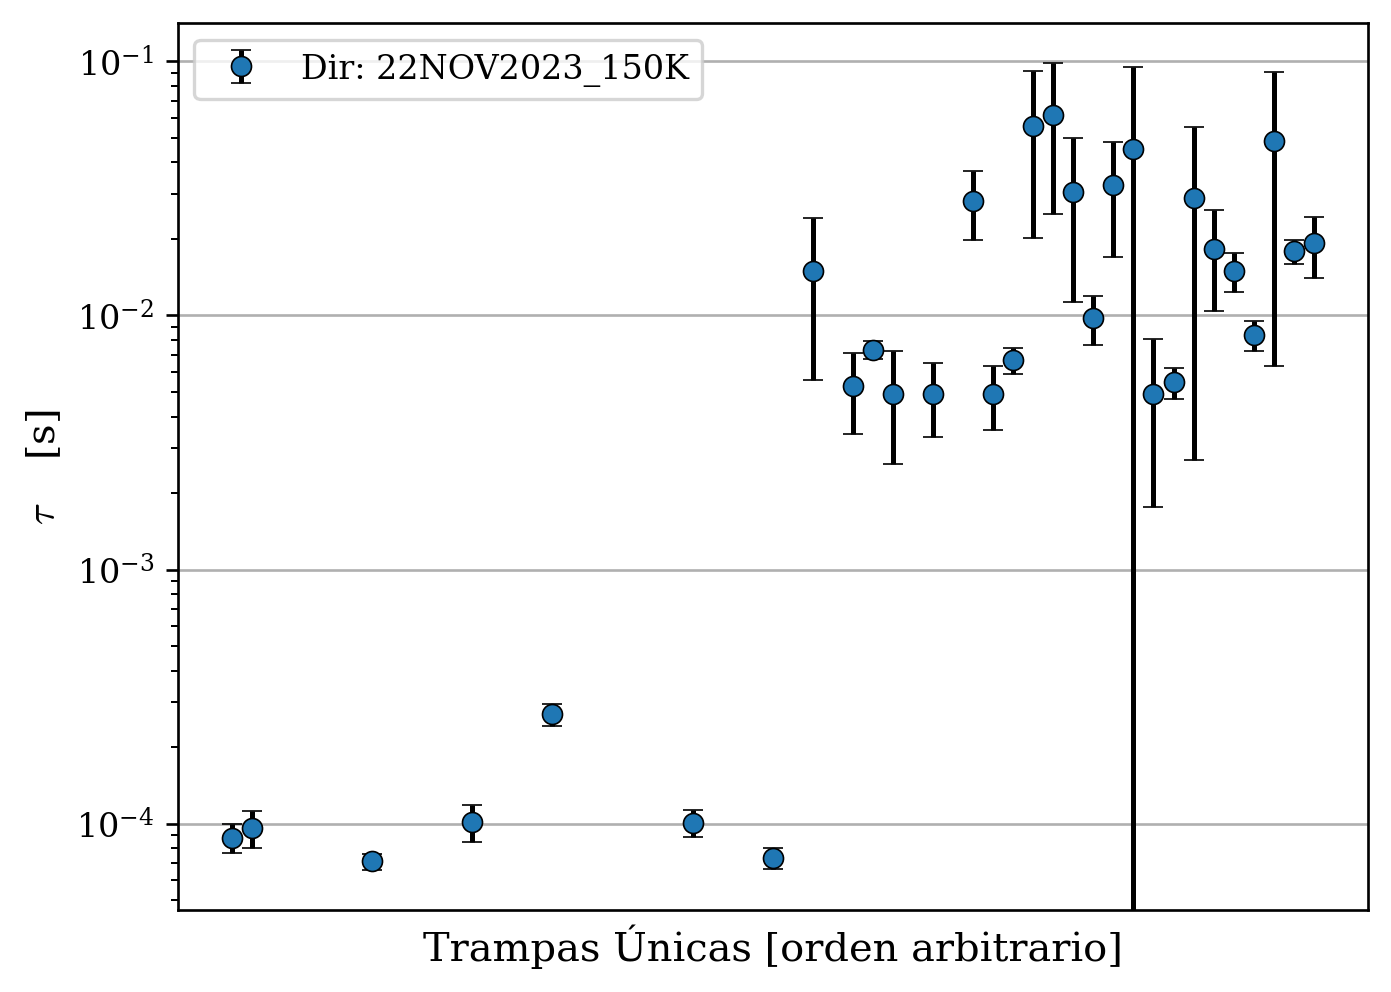

In [46]:
plt.close("all")
%matplotlib inline

if not "trampas_unicas" in locals():
    trampas_unicas = []  # [(frame_idx, coords_trampa), ...]
for frame_idx, trampas_frame in enumerate(fitted_traps):
    for dir_idx, trampas_dir in enumerate(trampas_frame):
        for trampa in trampas_dir:
            if (frame_idx, trampa) not in trampas_unicas:
                trampas_unicas.append((frame_idx, trampa))
union_tau_vals = np.full((len(CARPETAS_POR_TEMP[temperatura]), len(trampas_unicas)), np.nan)
union_tau_errs = np.full_like(union_tau_vals, np.nan)
for frame_idx in [0, 1]:
    for dir_idx, (trampas, tau_vals, tau_errs) in enumerate(
        zip(
            fitted_traps[frame_idx],
            fitted_tau_vals[frame_idx],
            fitted_tau_errs[frame_idx],    
        )
    ):
        for trampa_coord, tau_val, tau_err in zip(trampas, tau_vals, tau_errs):
            trap_idx = trampas_unicas.index((frame_idx, trampa_coord))
            union_tau_vals[dir_idx, trap_idx] = tau_val
            union_tau_errs[dir_idx, trap_idx] = tau_err

markers = ["o", "d"]
for dir_idx, (tau_vals, tau_errs) in enumerate(zip(union_tau_vals, union_tau_errs)):
    plt.errorbar(
        np.arange(len(tau_vals)), tau_vals/CLOCKS_TO_SEC, yerr=tau_errs/CLOCKS_TO_SEC,
        fmt=markers[dir_idx], mec="k", mew=0.5, capsize=3, ecolor="k", c=f"C{dir_idx%10}",
        label=f"Dir: {CARPETAS_POR_TEMP[temperatura][dir_idx].rsplit('/')[-2]}",
    )
    # print(dir_idx, tau_vals, tau_errs)
    # plt.plot(
        # np.arange(len(tau_vals)), tau_vals, 'o', mec="k", mew=0.5, c=f"C{dir_idx%10}"
    # )
plt.grid()
plt.legend()
plt.xticks([])
plt.xlabel("Trampas Únicas [orden arbitrario]")
plt.yscale("log")
plt.ylabel(r"$\tau\quad$ [s]")
plt.show()

In [47]:
# Concatenamos los resultados del análisis con mediciones previas:
if not "todos_tau_vals" in locals():
    todos_tau_vals = union_tau_vals
    todos_tau_errs = union_tau_errs
    temp_por_fila = {
        dir_idx: {
            "Temp": temperatura,
            "Dir": CARPETAS_POR_TEMP[temperatura][dir_idx].rsplit('/')[-2],
        } for dir_idx in range(len(union_tau_vals))
    }
else:
    filas_antes = len(todos_tau_vals)
    carpetas_cargadas = [temp_por_fila[i]["Dir"] for i in temp_por_fila]
    carpetas_a_cargar = [
        CARPETAS_POR_TEMP[temperatura][dir_idx].rsplit('/')[-2]
        for dir_idx in range(len(union_tau_vals))
    ]
    numero_trampas_antes = todos_tau_vals.shape[1]
    numero_trampas_ahora = union_tau_vals.shape[1]
    todos_tau_vals = np.pad(
        todos_tau_vals,
        ((0, 0), (0, numero_trampas_ahora - numero_trampas_antes)),
        mode="constant",
        constant_values=np.nan,
    )
    todos_tau_errs = np.pad(
        todos_tau_errs,
        ((0, 0), (0, numero_trampas_ahora - numero_trampas_antes)),
        mode="constant",
        constant_values=np.nan,
    )
    for dir_idx, (dir_name, tau_vals, tau_errs) in enumerate(
        zip(
            carpetas_a_cargar,
            union_tau_vals,
            union_tau_errs,
        )
    ):
        # if dir_name in carpetas_cargadas:
        #     if input("sobreescribir? [y/n] ") == "y":
        #         todos_tau_vals[filas_antes + dir_idx] = tau_vals
        #         todos_tau_errs[filas_antes + dir_idx] = tau_errs
        #         temp_por_fila[filas_antes + dir_idx] = {
        #             "Temp": temperatura,
        #             "Dir": carpetas_a_cargar[dir_idx]
        #         }
        todos_tau_vals = np.concatenate(
            (todos_tau_vals, tau_vals.reshape((1, -1))),
            axis=0)
        todos_tau_errs = np.concatenate(
            (todos_tau_errs, tau_errs.reshape((1, -1))),
            axis=0)
        temp_por_fila[filas_antes + dir_idx] = {
            "Temp": temperatura,
            "Dir": carpetas_a_cargar[dir_idx]
        }

In [48]:
temp_por_fila

{0: {'Temp': 127, 'Dir': '19NOV2023_127K'},
 1: {'Temp': 127, 'Dir': '20NOV2023_127K'},
 2: {'Temp': 135, 'Dir': '27NOV2023_135K'},
 3: {'Temp': 140, 'Dir': '23NOV2023_140K'},
 4: {'Temp': 145, 'Dir': '25NOV2023_145K'},
 5: {'Temp': 150, 'Dir': '22NOV2023_150K'}}

In [49]:
# Guardamos en archivos:
with open("skipper_image_analysis/TRAPS_results/trampas_unicas.pkl", "wb") as f:
    pickle.dump(trampas_unicas, f)
with open("skipper_image_analysis/TRAPS_results/temp_por_fila.pkl", "wb") as f:
    pickle.dump(temp_por_fila, f)
np.savez(
    "skipper_image_analysis/TRAPS_results/tau_vals.npz",
    todos_tau_vals=todos_tau_vals,
    todos_tau_errs=todos_tau_errs,
)

## Análisis de la Intensidad de las Trampas (Máximos)

In [34]:
plt.close('all')
%matplotlib widget
plot_example = False
temperatura = 150
trampas = [[], []]  # trampas[frame_idx][dir_idx][coord_idx]
intensidad = [[], []]  # intensidad[frame_idx][dir_idx][coord_idx][dtph_idx]
dtph = [[], []]  # dtph[frame_idx][dir_idx][coord_idx][dtph_idx]
error = [[], []]  # error[frame_idx][dir_idx][dtph_idx]
for frame_idx in [0, 1]:
    for dir_idx in range(len(CARPETAS_POR_TEMP[temperatura])):
        coords_dict, frames_dict, vals_dict, mascara_dipolos, test_image, err = carga_archivos(
            temperatura, dir_idx, frame_idx
        )
        trampas_halladas, intensidad_por_trampa, dtph_vals = identificacion_e_intensidad(
            coords_dict, frames_dict
        )
        #print(trampas_halladas[4])
        #print(intensidad_por_trampa[4])
        if plot_example:
            grafico_trampas_por_carpeta(frame_idx, test_image, trampas_halladas)
            plot_example = False
        trampas[frame_idx].append(trampas_halladas)
        intensidad[frame_idx].append(intensidad_por_trampa)
        dtph[frame_idx].append(dtph_vals)
        error[frame_idx].append(err)


Procesando Archivos:   0%|          | 0/20 [00:00<?, ?it/s]

Recorriendo dTph:   0%|          | 0/20 [00:00<?, ?it/s]

Procesando Archivos:   0%|          | 0/20 [00:00<?, ?it/s]

Recorriendo dTph:   0%|          | 0/20 [00:00<?, ?it/s]

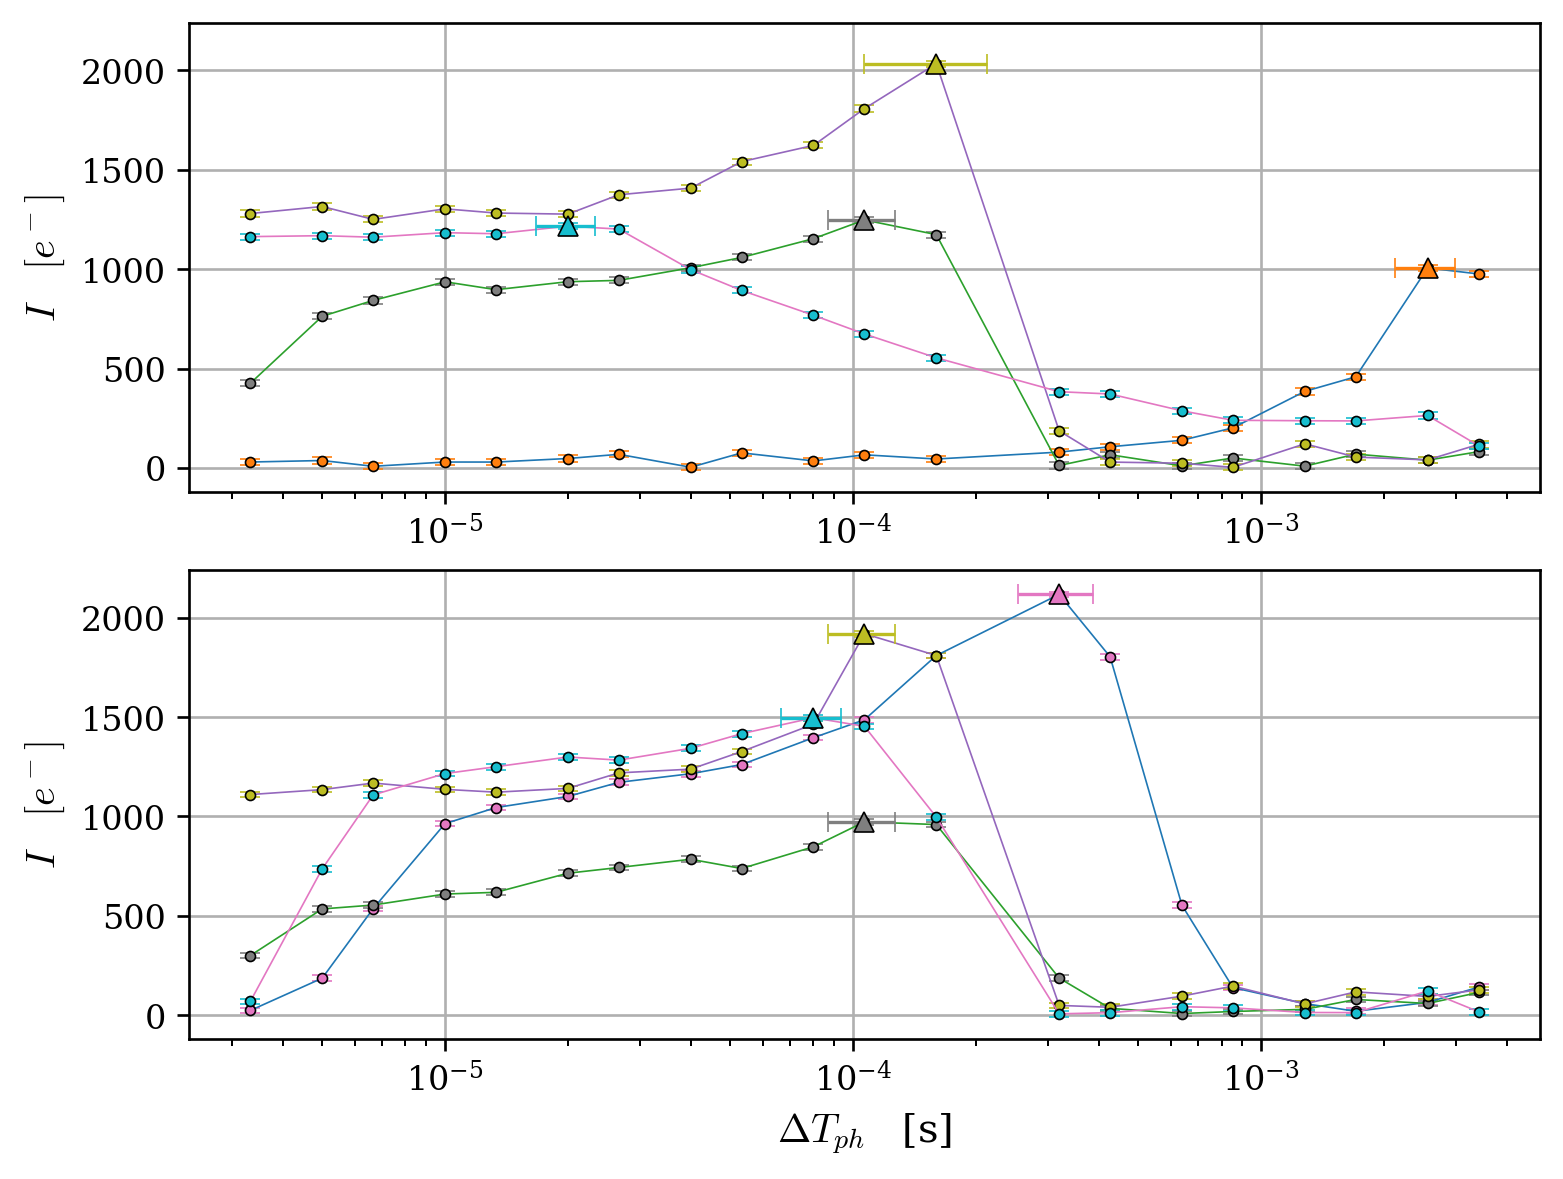

In [35]:
plt.close("all")
%matplotlib inline
fitted_traps = [[], []]
fitted_tau_vals = [[], []]
fitted_tau_errs = [[], []]
fig, axs = plt.subplots(
    2, 1, #len(CARPETAS_POR_TEMP[temperatura]),  # 2 frames por barrido
    squeeze=False, constrained_layout=True, sharey=True,
)

for frame_idx, ax_row in enumerate(axs):
    ax = ax_row[0]
    for dir_idx, (trampas_halladas, intensidad_por_trampa, err_vals, dtph_vals,) in enumerate(
        zip(trampas[frame_idx], intensidad[frame_idx], error[frame_idx], dtph[frame_idx])
    ):
        err_vals = np.array([err_vals[dtph] for dtph in dtph_vals])/np.sqrt(2) * 5
        fitted_traps[frame_idx].append([])
        fitted_tau_vals[frame_idx].append([])
        fitted_tau_errs[frame_idx].append([])
        dtph_dense = np.geomspace(min(dtph_vals), max(dtph_vals), 1000)
        for i, (trampa, intensidades) in enumerate(
            zip(trampas_halladas, intensidad_por_trampa)
        ):
            # Busqueda del Máximo:
            idx_pico = np.argmax(intensidades)
            dtph_maxval = dtph_vals[idx_pico]
            intensidad_maxval = intensidades[idx_pico]
            ancho = np.mean(
                (np.diff(dtph_vals)[idx_pico-1:idx_pico+1])/2
            ) 
            if (idx_pico == 0) or (idx_pico == len(intensidades)-1):
                continue
            # Verifico que el máximo sea un máximo local suave y no un pico de ruido:
            intensidades_sin_pico = np.concatenate(
                (intensidades[:idx_pico], intensidades[idx_pico+1:])
            )  # Calculo las intensidades sin el pico y me fijo si los vecinos del pico
            # son los valores más altos de la intensidad. Si no, no es un máximo local
            # suave y no lo considero.
            if np.argmax(intensidades_sin_pico) in [idx_pico, idx_pico-1]:
                c = f"C{(i + dir_idx*5)%10}"
                ax.errorbar(
                    np.array(dtph_vals)/CLOCKS_TO_SEC,
                    intensidades,
                    yerr=err_vals,
                    fmt='.-', markerfacecolor=c, markeredgecolor="k", markeredgewidth=0.5,
                    capsize=3, ecolor=c, elinewidth=1, lw=0.5,
                    # label=f"({dir_idx}, {frame_idx}, {i})"
                )
                ax.errorbar(
                    [dtph_maxval/CLOCKS_TO_SEC],
                    [intensidad_maxval],
                    xerr=[ancho/CLOCKS_TO_SEC],
                    fmt='^', markerfacecolor=c, markeredgecolor="k", markeredgewidth=0.5,
                    capsize=3, ecolor=c, elinewidth=1, lw=1, zorder=10)
                fitted_traps[frame_idx][dir_idx].append(trampa)
                fitted_tau_vals[frame_idx][dir_idx].append(dtph_maxval)
                fitted_tau_errs[frame_idx][dir_idx].append(ancho)
    ax.grid(True)
    # ax.legend()
    ax.set_xscale("log")
    # ax.set_xlim(0, 15000)
    ax.set_ylabel(r"$I\quad [e^-]$")
ax.set_xlabel(r"$\Delta T_{ph}\quad$[s]")
plt.show()

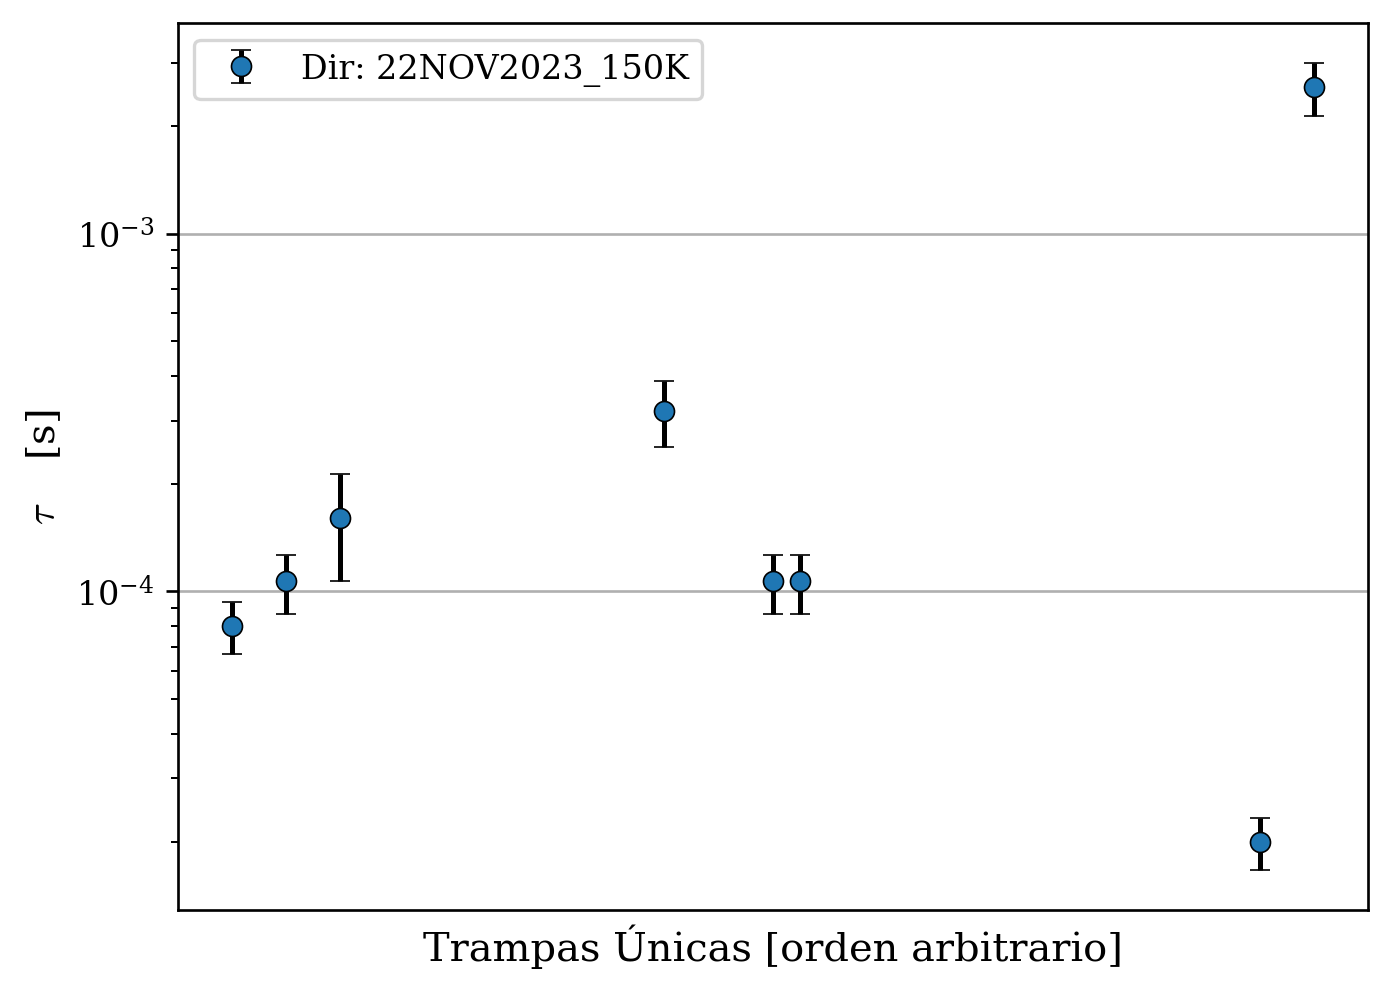

In [36]:
plt.close("all")
%matplotlib inline

if not "trampas_unicas" in locals():
    trampas_unicas = []  # [(frame_idx, coords_trampa), ...]
for frame_idx, trampas_frame in enumerate(fitted_traps):
    for dir_idx, trampas_dir in enumerate(trampas_frame):
        for trampa in trampas_dir:
            if (frame_idx, trampa) not in trampas_unicas:
                trampas_unicas.append((frame_idx, trampa))
union_tau_vals = np.full((len(CARPETAS_POR_TEMP[temperatura]), len(trampas_unicas)), np.nan)
union_tau_errs = np.full_like(union_tau_vals, np.nan)
for frame_idx in [0, 1]:
    for dir_idx, (trampas, tau_vals, tau_errs) in enumerate(
        zip(
            fitted_traps[frame_idx],
            fitted_tau_vals[frame_idx],
            fitted_tau_errs[frame_idx],    
        )
    ):
        for trampa_coord, tau_val, tau_err in zip(trampas, tau_vals, tau_errs):
            trap_idx = trampas_unicas.index((frame_idx, trampa_coord))
            union_tau_vals[dir_idx, trap_idx] = tau_val
            union_tau_errs[dir_idx, trap_idx] = tau_err

markers = ["o", "d"]
for dir_idx, (tau_vals, tau_errs) in enumerate(zip(union_tau_vals, union_tau_errs)):
    plt.errorbar(
        np.arange(len(tau_vals)), tau_vals/CLOCKS_TO_SEC, yerr=tau_errs/CLOCKS_TO_SEC,
        fmt=markers[dir_idx], mec="k", mew=0.5, capsize=3, ecolor="k", c=f"C{dir_idx%10}",
        label=f"Dir: {CARPETAS_POR_TEMP[temperatura][dir_idx].rsplit('/')[-2]}",
    )
    # print(dir_idx, tau_vals, tau_errs)
    # plt.plot(
        # np.arange(len(tau_vals)), tau_vals, 'o', mec="k", mew=0.5, c=f"C{dir_idx%10}"
    # )
plt.grid()
plt.legend()
plt.xticks([])
plt.xlabel("Trampas Únicas [orden arbitrario]")
plt.yscale("log")
plt.ylabel(r"$\tau\quad$ [s]")
plt.show()

In [37]:
# Concatenamos los resultados del análisis con mediciones previas:
if not "todos_tau_vals" in locals():
    todos_tau_vals = union_tau_vals
    todos_tau_errs = union_tau_errs
    temp_por_fila = {
        dir_idx: {
            "Temp": temperatura,
            "Dir": CARPETAS_POR_TEMP[temperatura][dir_idx].rsplit('/')[-2],
        } for dir_idx in range(len(union_tau_vals))
    }
else:
    filas_antes = len(todos_tau_vals)
    carpetas_cargadas = [temp_por_fila[i]["Dir"] for i in temp_por_fila]
    carpetas_a_cargar = [
        CARPETAS_POR_TEMP[temperatura][dir_idx].rsplit('/')[-2]
        for dir_idx in range(len(union_tau_vals))
    ]
    numero_trampas_antes = todos_tau_vals.shape[1]
    numero_trampas_ahora = union_tau_vals.shape[1]
    todos_tau_vals = np.pad(
        todos_tau_vals,
        ((0, 0), (0, numero_trampas_ahora - numero_trampas_antes)),
        mode="constant",
        constant_values=np.nan,
    )
    todos_tau_errs = np.pad(
        todos_tau_errs,
        ((0, 0), (0, numero_trampas_ahora - numero_trampas_antes)),
        mode="constant",
        constant_values=np.nan,
    )
    for dir_idx, (dir_name, tau_vals, tau_errs) in enumerate(
        zip(
            carpetas_a_cargar,
            union_tau_vals,
            union_tau_errs,
        )
    ):
        # if dir_name in carpetas_cargadas:
        #     if input("sobreescribir? [y/n] ") == "y":
        #         todos_tau_vals[filas_antes + dir_idx] = tau_vals
        #         todos_tau_errs[filas_antes + dir_idx] = tau_errs
        #         temp_por_fila[filas_antes + dir_idx] = {
        #             "Temp": temperatura,
        #             "Dir": carpetas_a_cargar[dir_idx]
        #         }
        todos_tau_vals = np.concatenate(
            (todos_tau_vals, tau_vals.reshape((1, -1))),
            axis=0)
        todos_tau_errs = np.concatenate(
            (todos_tau_errs, tau_errs.reshape((1, -1))),
            axis=0)
        temp_por_fila[filas_antes + dir_idx] = {
            "Temp": temperatura,
            "Dir": carpetas_a_cargar[dir_idx]
        }

In [38]:
temp_por_fila

{0: {'Temp': 127, 'Dir': '19NOV2023_127K'},
 1: {'Temp': 127, 'Dir': '20NOV2023_127K'},
 2: {'Temp': 135, 'Dir': '27NOV2023_135K'},
 3: {'Temp': 140, 'Dir': '23NOV2023_140K'},
 4: {'Temp': 145, 'Dir': '25NOV2023_145K'},
 5: {'Temp': 150, 'Dir': '22NOV2023_150K'}}

In [39]:
# Guardamos en archivos:
with open("skipper_image_analysis/TRAPS_MAX_results/trampas_unicas.pkl", "wb") as f:
    pickle.dump(trampas_unicas, f)
with open("skipper_image_analysis/TRAPS_MAX_results/temp_por_fila.pkl", "wb") as f:
    pickle.dump(temp_por_fila, f)
np.savez(
    "skipper_image_analysis/TRAPS_MAX_results/tau_vals.npz",
    todos_tau_vals=todos_tau_vals,
    todos_tau_errs=todos_tau_errs,
)

## Análisis de $\tau(T)$ para las Trampas

In [167]:
# Cargamos desde archivos:
RESULTS_DIR = "skipper_image_analysis/TRAPS_MAX_results"
# RESULTS_DIR = "skipper_image_analysis/TRAPS_results"
try:
    with open(f"{RESULTS_DIR}/trampas_unicas.pkl", "rb") as f:
        trampas_unicas = pickle.load(f)
    with open(f"{RESULTS_DIR}/temp_por_fila.pkl", "rb") as f:
        temp_por_fila = pickle.load(f)
    tau_vals_dict = np.load(f"{RESULTS_DIR}/tau_vals.npz", )
    todos_tau_vals = tau_vals_dict["todos_tau_vals"]
    todos_tau_errs = tau_vals_dict["todos_tau_errs"]
    print(f"Resultados cargados desde {RESULTS_DIR}")
except FileNotFoundError:
    print("No encontré archivos.")

Resultados cargados desde skipper_image_analysis/TRAPS_MAX_results


In [168]:
todos_tau_vals_stat = []
todos_tau_errs_stat = []
temp_por_fila_stat = []
for row_num, info in temp_por_fila.items():
    if info['Temp'] not in temp_por_fila_stat:
        temp_por_fila_stat.append(info['Temp'])
        todos_tau_vals_stat.append([todos_tau_vals[row_num]])
        todos_tau_errs_stat.append([todos_tau_errs[row_num]])
    else:
        idx = temp_por_fila_stat.index(info['Temp'])
        todos_tau_vals_stat[idx].append(todos_tau_vals[row_num])
        todos_tau_errs_stat[idx].append(todos_tau_errs[row_num])

for temp, taus, errs in zip(temp_por_fila_stat, todos_tau_vals_stat, todos_tau_errs_stat):
    idx = temp_por_fila_stat.index(temp)
    if len(taus) > 1:
        stacked_taus = np.stack(taus)
        todos_tau_vals_stat[idx] = np.nanmean(stacked_taus, axis=0)
        todos_tau_errs_stat[idx] = np.nanstd(stacked_taus, axis=0)
    else:
        todos_tau_vals_stat[idx] = taus[0]
        todos_tau_errs_stat[idx] = errs[0]

todos_tau_vals_stat = np.stack(todos_tau_vals_stat, axis=-1)
todos_tau_errs_stat = np.stack(todos_tau_errs_stat, axis=-1)

/tmp/ipykernel_28529/4000321073.py:18: RuntimeWarning: Mean of empty slice
  todos_tau_vals_stat[idx] = np.nanmean(stacked_taus, axis=0)
/home/agustin/Documents/FCEN/2023_1er_Cuatrimestre/Laboratorio_6&7/LAMBDA_Hub/lambda_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [169]:
temp_por_fila_stat, todos_tau_vals_stat.shape

([127, 135, 140, 145, 150], (54, 5))

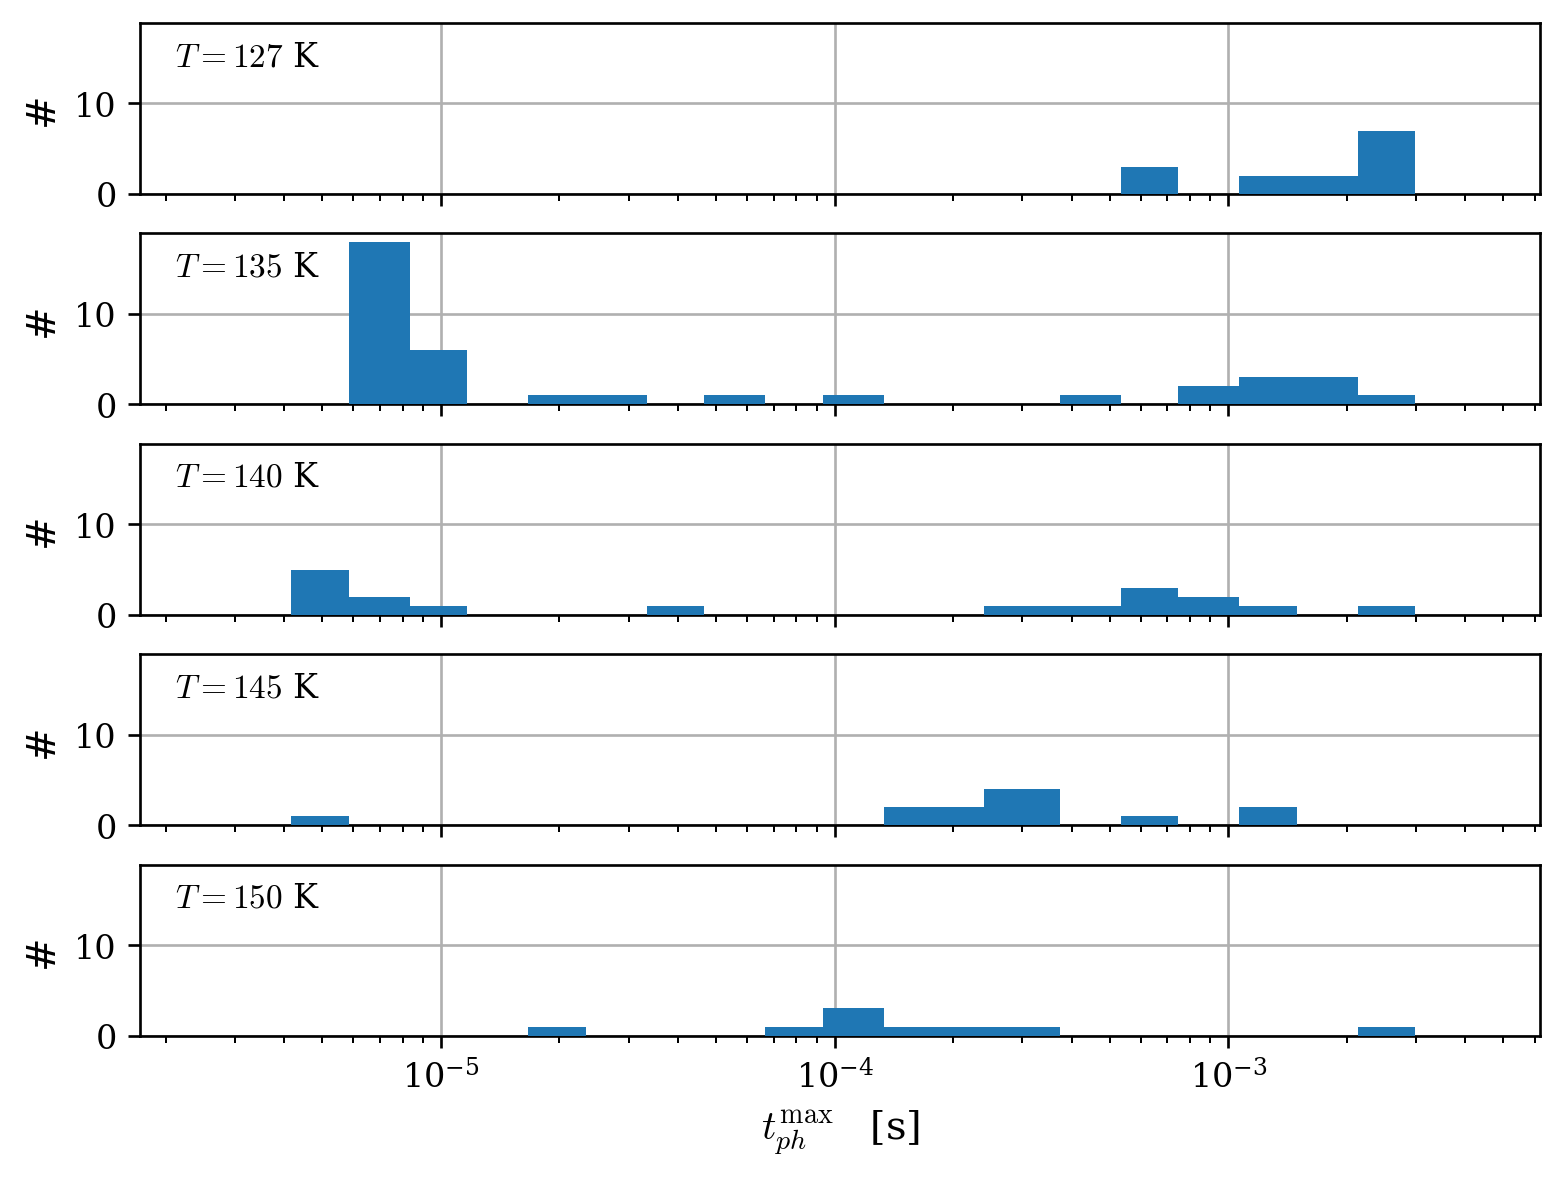

In [170]:
plt.close("all")
%matplotlib inline
fig, axs = plt.subplots(len(temp_por_fila_stat), 1, constrained_layout=True, sharex=True, sharey=True)
# bin_edges = np.geomspace(
#     dtph_vals[0], dtph_vals[-1]*16, 25
# ) / np.log(2)
bin_edges = np.concatenate(
    [
        [dtph_vals[0]*0.75],
        np.array(dtph_vals[:-1])/2 + np.array(dtph_vals[1:])/2, 
        [dtph_vals[-1]*1.25],
    ]
)
for row_num, tau_vals in enumerate(todos_tau_vals_stat.T):
    temp = temp_por_fila_stat[row_num]
    axs[row_num].hist(
        tau_vals/CLOCKS_TO_SEC, bins=bin_edges/CLOCKS_TO_SEC,
        zorder=10+row_num, density=False
    )
    axs[row_num].grid()
    # axs[row_num].set_title(f"$T = {temp}$ [K]", loc="left")
    axs[row_num].text(
        0.025, 0.9, f"$T = {temp}$ K", transform=axs[row_num].transAxes,
        va="top", ha="left",
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round'),
    )
    # axs[row_num].xlim(0, 10)
    axs[row_num].set_xscale("log")
    # axs[row_num].set_yscale("log")
    axs[row_num].set_ylabel("#")
# axs[row_num].set_xlabel(r"$\tau_e\quad$[s]")
axs[row_num].set_xlabel(r"$t_{ph}^\mathrm{max}\quad$[s]")
plt.show()

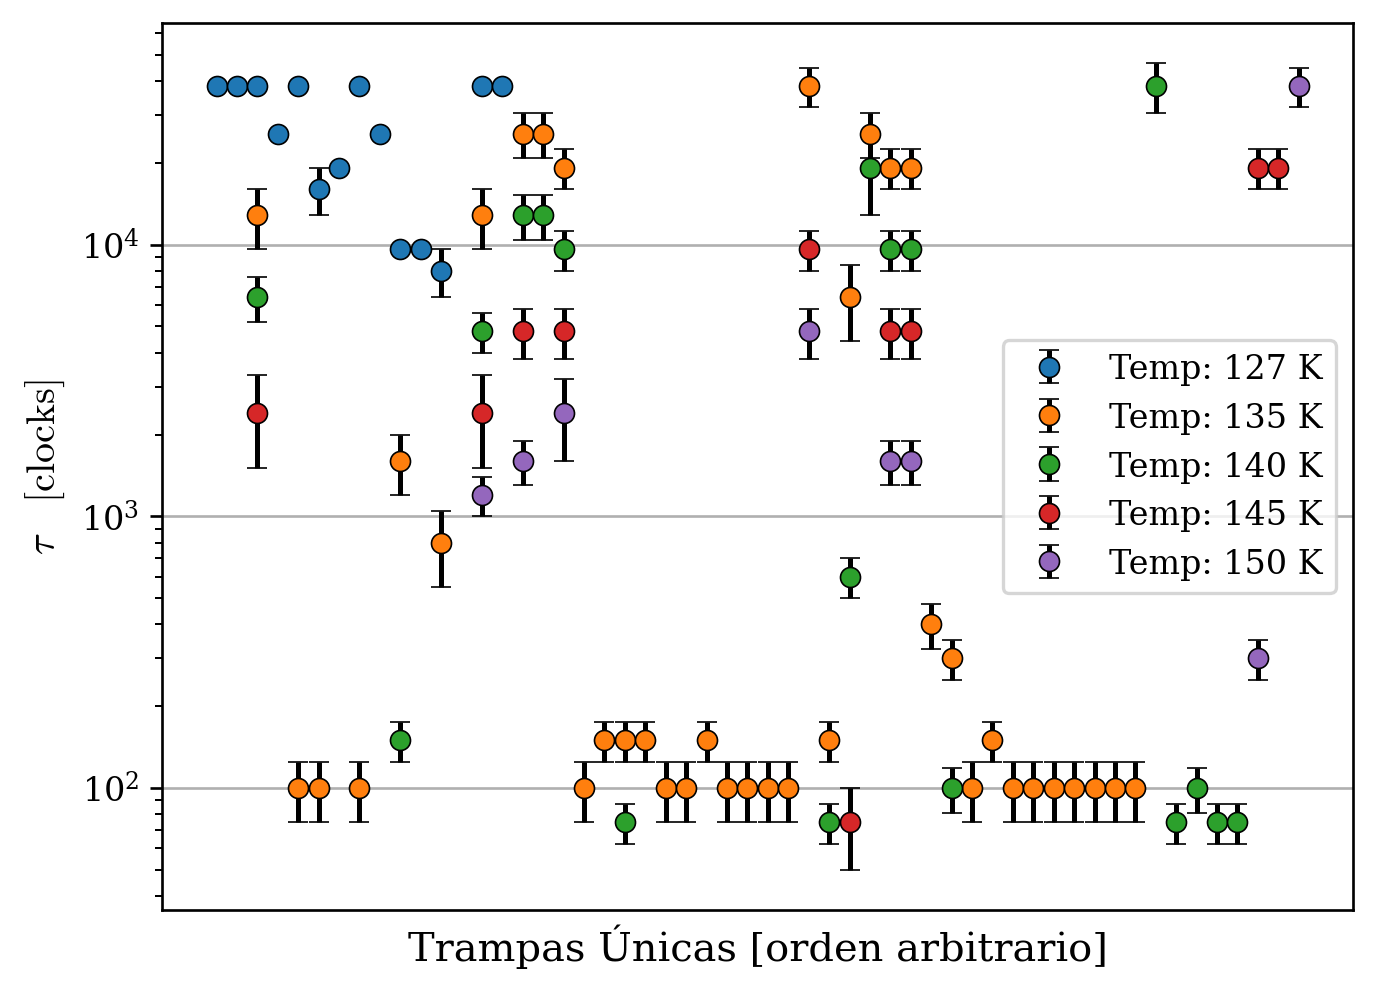

In [125]:
plt.close("all")
%matplotlib inline
markers = ["o", "d"]
for row_num, (tau_vals, tau_errs) in enumerate(zip(todos_tau_vals_stat.T, todos_tau_errs_stat.T)):
    temp = temp_por_fila_stat[row_num]
    plt.errorbar(
        np.arange(len(trampas_unicas)), tau_vals, yerr=tau_errs,
        fmt="o", mec="k", mew=0.5, capsize=3, ecolor="k", c=f"C{row_num%10}",
        label=f"Temp: {temp} K",
    )
plt.grid()
plt.legend()
plt.xticks([])
plt.xlabel("Trampas Únicas [orden arbitrario]")
# plt.xlim(0, 10)
plt.yscale("log")
plt.ylabel(r"$\tau\quad [\mathrm{clocks}]$")
plt.show()

$$\tau_e = \frac{h^2}{2\sigma m_e \sqrt{3}\left(2\pi\right)^{3/2} \left(k_B T\right)^2}  \exp\left(\frac{E}{k_B T}\right)$$

/tmp/ipykernel_28529/1734761520.py:32: RuntimeWarning: divide by zero encountered in divide
  (tau_fit - tau_func(np.array(temp_fit), *popt))
/tmp/ipykernel_28529/1734761520.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_red = np.sum(


4	2	2	3	2	5	4	2	4	2	3	2	2	4	4	2	

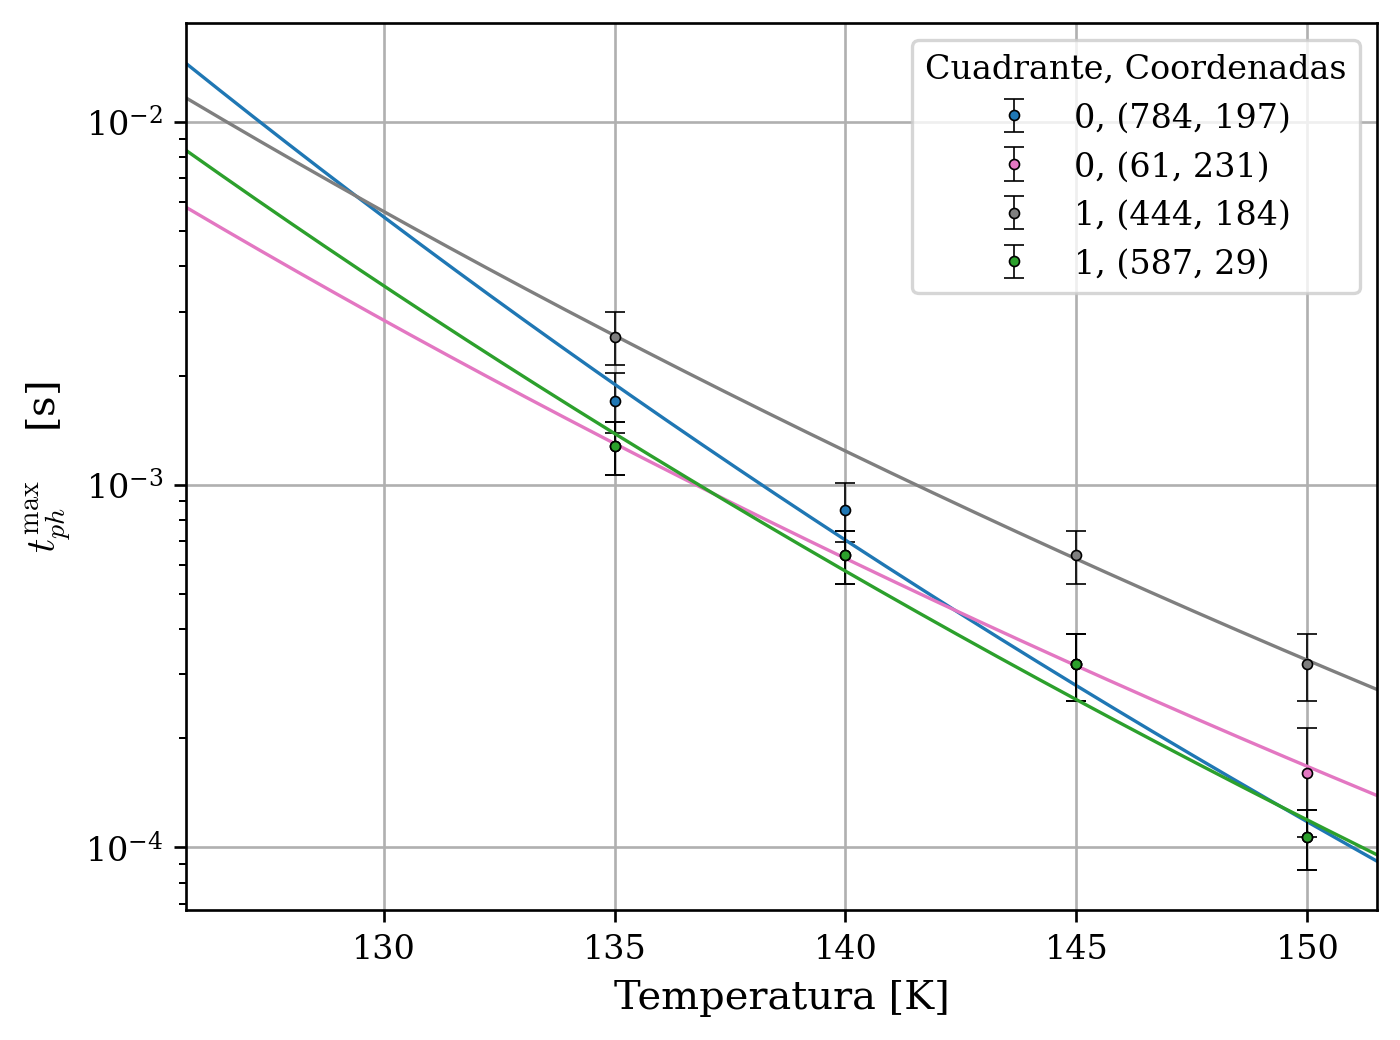

In [184]:
def tau_func(T, e_kb, tau_0):
    return tau_0/(T**2)*np.exp(e_kb/T)


# temp_vals = [temp_por_fila[i]["Temp"] for i in range(len(todos_tau_vals))]
temp_vals = temp_por_fila_stat
temp_dense = np.linspace(min(temp_vals)*0.99, max(temp_vals)*1.01, 1000)
# norm = plt.Normalize(0, len(trampas_unicas))
# colors = plt.cm.ScalarMappable(norm=norm, cmap="inferno").to_rgba
color_id = 0
colors = ["C0", "C6", "C7", "C2", "C4"]
for i_trampa, (tau_vals_trampa, tau_errs_trampa, trampa_coord) in enumerate(
    zip(
        todos_tau_vals_stat, todos_tau_errs_stat, trampas_unicas
    )
):
    if sum(~np.isnan(tau_vals_trampa)) < 2:
        continue
    temp_fit = np.array(temp_vals)[~np.isnan(tau_vals_trampa)]
    tau_fit = np.array(tau_vals_trampa)[~np.isnan(tau_vals_trampa)]
    tau_err_fit = np.array(tau_errs_trampa)[~np.isnan(tau_vals_trampa)]
    try:
        popt, pcov = curve_fit(
            tau_func, temp_fit, tau_fit, sigma=tau_err_fit,
        )
    except RuntimeError:
        continue
    # Test de Chi²
    grados_libertad = len(temp_fit) - len(popt)
    chi2_red = np.sum(
        (
            (tau_fit - tau_func(np.array(temp_fit), *popt))
            /tau_err_fit
        )**2) / grados_libertad
    p_value = chi2.sf(chi2_red, grados_libertad)
    # print(f"p = {p_value:.1g}", end="\t")
    print(len(temp_fit), end="\t")
    if (trampa_coord[0] == 1) & (trampa_coord[1][0] == (584, 93)):
        continue        
    if p_value > 1e-2:
        plt.errorbar(
            temp_fit, tau_fit/CLOCKS_TO_SEC, yerr=tau_err_fit/CLOCKS_TO_SEC,
            fmt=".", mec="k", mew=0.5, capsize=3, ecolor="k", lw=0.5,
            # label=f"{trampa_coord[0]} | {trampa_coord[1]}",
            # label=f"{p_value:.2f}",
            label=f"{trampa_coord[0]}, {trampa_coord[1][0]}",
            # c=f"C{color_id%10}",
            c=colors[color_id],
            # c=colors(i_trampa),
        )
        
        plt.plot(
            temp_dense, tau_func(temp_dense, *popt)/CLOCKS_TO_SEC, '-', lw=1,
            c=colors[color_id],  # f"C{color_id%10}",  # c=colors(i_trampa)
        )
        color_id += 1
        # Espectro de Trampas a 127 K reconstruido con $\tau(T)$
plt.grid()
plt.legend(
    # title="F | Coordenadas",
    # title="$p$-valor",
    title="Cuadrante, Coordenadas",
    bbox_to_anchor=(1, 1),
    loc='upper right',
)
plt.xlim(temp_dense[0], temp_dense[-1])
plt.xlabel("Temperatura [K]")
plt.yscale("log")
# plt.ylim(top=1e5/CLOCKS_TO_SEC)
# plt.ylabel(r"$\tau_e\quad$ [s]")
plt.ylabel(r"$t_{ph}^\mathrm{max} \quad$ [s]")
plt.show()

# Old

In [24]:
"""Hay que cambiar esta parte para que cree tantos dtph_i como tandas de mediciones 
haya para la misma temp automaticamente."""
dtph_0 = set(dtph[0])
#dtph_1 = set(dtph[1])
#union_dtph = dtph_0|dtph_1
union_dtph = dtph_0
union_dtph = sorted(union_dtph)


trampas_0 = set(trampas[0])
#trampas_1 = set(trampas[1])
#union_trampas = trampas_0|trampas_1
union_trampas = trampas_0
#me armo el objeto que tenga las intensidades promedio para cada trampa y dtph
intensidades_promediadas = [0]*len(union_trampas)

for i in range(len(intensidades_promediadas)):
    intensidades_promediadas[i] = [0]*len(union_dtph)

contador = np.zeros_like(intensidades_promediadas)  # para llevar registro de cuantos elementos sumé para promediar

for dir_idx in range(len(CARPETAS_POR_TEMP[temperatura])):
    for trampa in union_trampas:
        if trampa in trampas[dir_idx]:
            k = trampas[dir_idx].index(trampa)
            l = list(union_trampas).index(trampa)
            for  i, tph in enumerate(union_dtph):
                #print(tph)
                if tph in dtph[dir_idx]:
                    j = dtph[dir_idx].index(tph)
                    #print(j)
                    contador[l][i] = contador[l][i]+1
                    intensidades_promediadas[l][i] = intensidades_promediadas[l][i] +intensidad[dir_idx][k][j]


"""si por ejemplo una trampa solo la detecté en un archivo y justo en ese archivo
hay un dtph que no tengo, intensidades trampas en ese elemento va a ser cero y contador también.
No puedo dividir por cero para hacer el promedio así que todos los elementos nulos de contador
los mando a 1:
"""
for i in range(len(contador)):
    for j in range(len(contador[0])):
        if contador[i][j] == 0 :
            contador[i][j] = 1

"""Lo malo de esto es que si una trampa solo la tengo en un archivo, en el cual no hay
un determinado dtph, la intensidad de esa trampa en ese dtph va a ser cero, cosa que jode
para el ajuste"""

#calculo el promedio
for i in range(len(union_trampas)):
    for j in range(len(union_dtph)):
        intensidades_promediadas[i][j] = intensidades_promediadas[i][j]/contador[i][j]

TypeError: unhashable type: 'list'

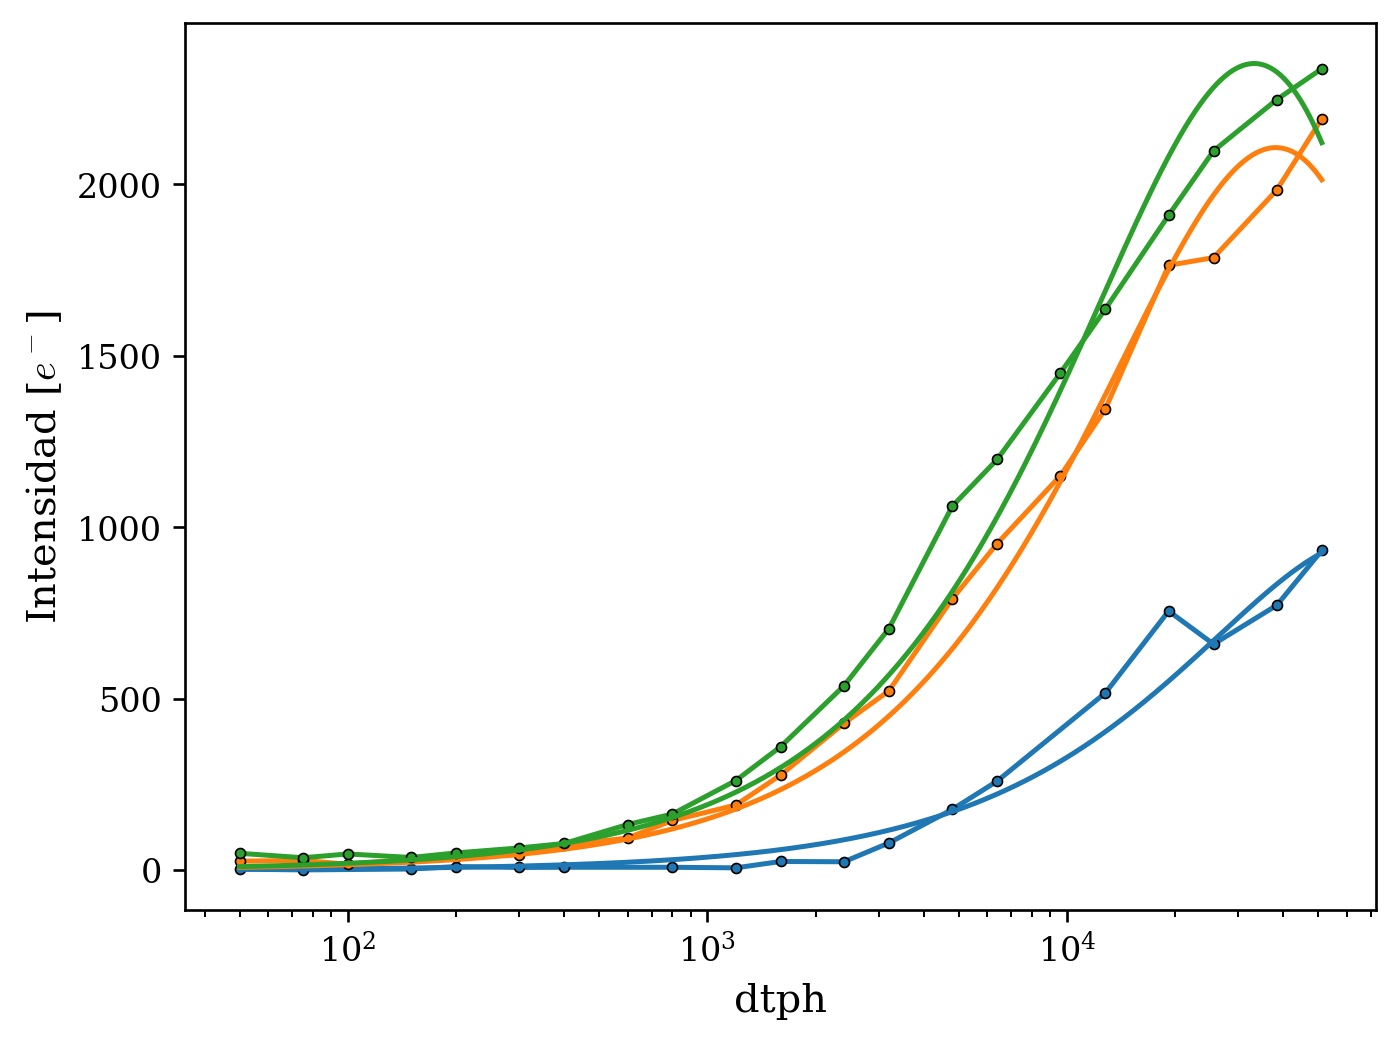

13
{((812, 98), (811, 98)), ((34, 172), (33, 172)), ((784, 197), (783, 197)), ((565, 99), (564, 99)), ((519, 30), (518, 30)), ((319, 240), (318, 240)), ((61, 231), (62, 231)), ((826, 35), (827, 35)), ((779, 152), (778, 152)), ((147, 12), (146, 12)), ((338, 258), (337, 258)), ((625, 22), (624, 22)), ((206, 84), (207, 84))}
3
{127: [101676.12321615986, 55043.098626985746, 47894.82598294484]}


In [7]:
plt.close("all") 
%matplotlib inline
tau = dict()
tau_ajuste = []
index = 3
#for i in range(len(intensidades_promediadas)):
    #print(f"largo de lista de int:{len(intensidades_promediadas[i])}")

#print(len(intensidad_por_trampa))
for i, intensidades in enumerate(intensidades_promediadas[index:index+3]):
    intensidades_ajuste = []
    dtph_ajuste = []
    """si hay algun elemento de intensidades que vale 0 debido a como calculo los promedios
     lo elimino para hacer el ajuste """
    for j in range(len(intensidades)):
        #print(j)
        if intensidades[j] == 0:
            #print("hay un cero")   
            continue
        intensidades_ajuste.append(intensidades[j])
        dtph_ajuste.append(union_dtph[j])
    #print(dtph_ajuste)
    #print(intensidades_ajuste)
    plt.plot(dtph_ajuste, intensidades_ajuste , '.-', mec="k", mew=0.5, c=f"C{i%10}")
    popt, pcov = curve_fit(intensidad_func, union_dtph, intensidades, p0=[1000, 1000])
    tau_ajuste.append(popt[0])
    dtph_dense = np.geomspace(min(union_dtph), max(union_dtph), 1000)
    plt.plot(dtph_dense, intensidad_func(dtph_dense, *popt))
plt.xlabel("dtph")
plt.ylabel(r"Intensidad [$e^-$]")
plt.xscale("log")
plt.show()
tau[temperatura] = tau_ajuste
print(len(union_trampas))
print(union_trampas)
print(len(tau[temperatura]))
print(tau)

## Imágenes LAMBDA

In [16]:
# Cargar Archivos desde sus Carpetas por Temperatura

temperatura = 140
data_dir = CARPETAS_POR_TEMP[temperatura][-1]
files_in_dir = os.listdir(data_dir)
valid_formats = ["fits",]  # "fz"]
files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
file_data = [f"{i}    " + "    ".join(filename.split("_")[2:]) for i, filename in enumerate(files_in_dir)]
print("Params in .fits Files in Directory:", *file_data, sep="\n")
i = -4
test_image = fits.open(f'{data_dir}/{files_in_dir[i]}')
print(f"\nLoaded {files_in_dir[i]}\n")


Params in .fits Files in Directory:
0    pocket    oled1row    2film    dTph100    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img91.fits
1    pocket    oled1row    2film    dTph1200    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img105.fits
2    pocket    oled1row    2film    dTph12800    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img119.fits
3    pocket    oled1row    2film    dTph150    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img93.fits
4    pocket    oled1row    2film    dTph1600    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img107.fits
5    pocket    oled1row    2film    dTph19200    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img121.fits
6    pocket    oled1row    2film    dTph200    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img95.fits
7    pocket    oled1row    2film    dTph2400    NPUPMPS40000    NSAMP20    NROW879    NCOL336    EXP

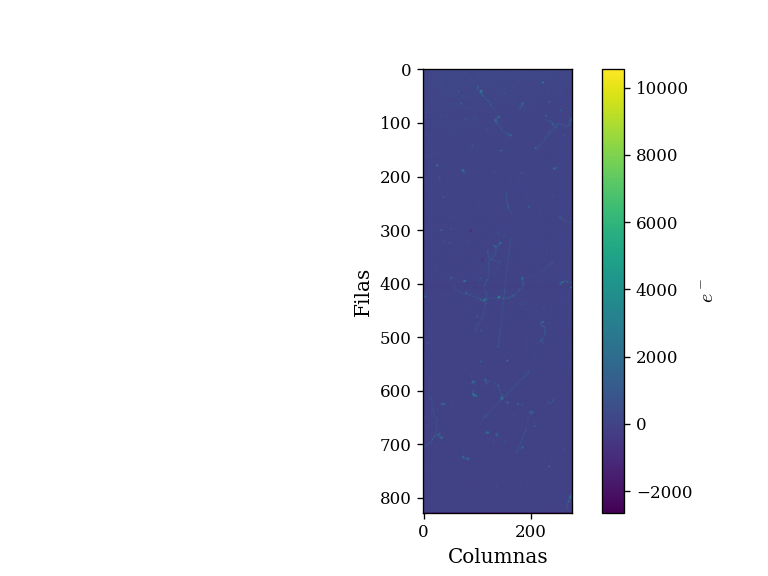

In [17]:
# Lectura del Frame y Corrección del Overscan
frame_idx = 0
test_frame = prepare_frame(test_image, frame_idx)  # e⁻

plt.close("all")
%matplotlib widget
fig, ax = plt.subplots(1, 1)
fig.set_label(f"Frame {frame_idx}")
mappable = ax.imshow(test_frame, cmap="viridis")
ax.set_xlabel("Columnas")
ax.set_ylabel("Filas")
# ax.set_xlim(100, 150)
# ax.set_ylim(100, 150)
plt.colorbar(mappable, label=r"$e^-$", ax=ax)
plt.show()
#print(test_frame)

In [78]:
threshold = 5e5
corte_simetria = 20
coordenadas_trampas, val_trampas, mascara = filtro_dipolos(test_frame, threshold, corte_simetria)

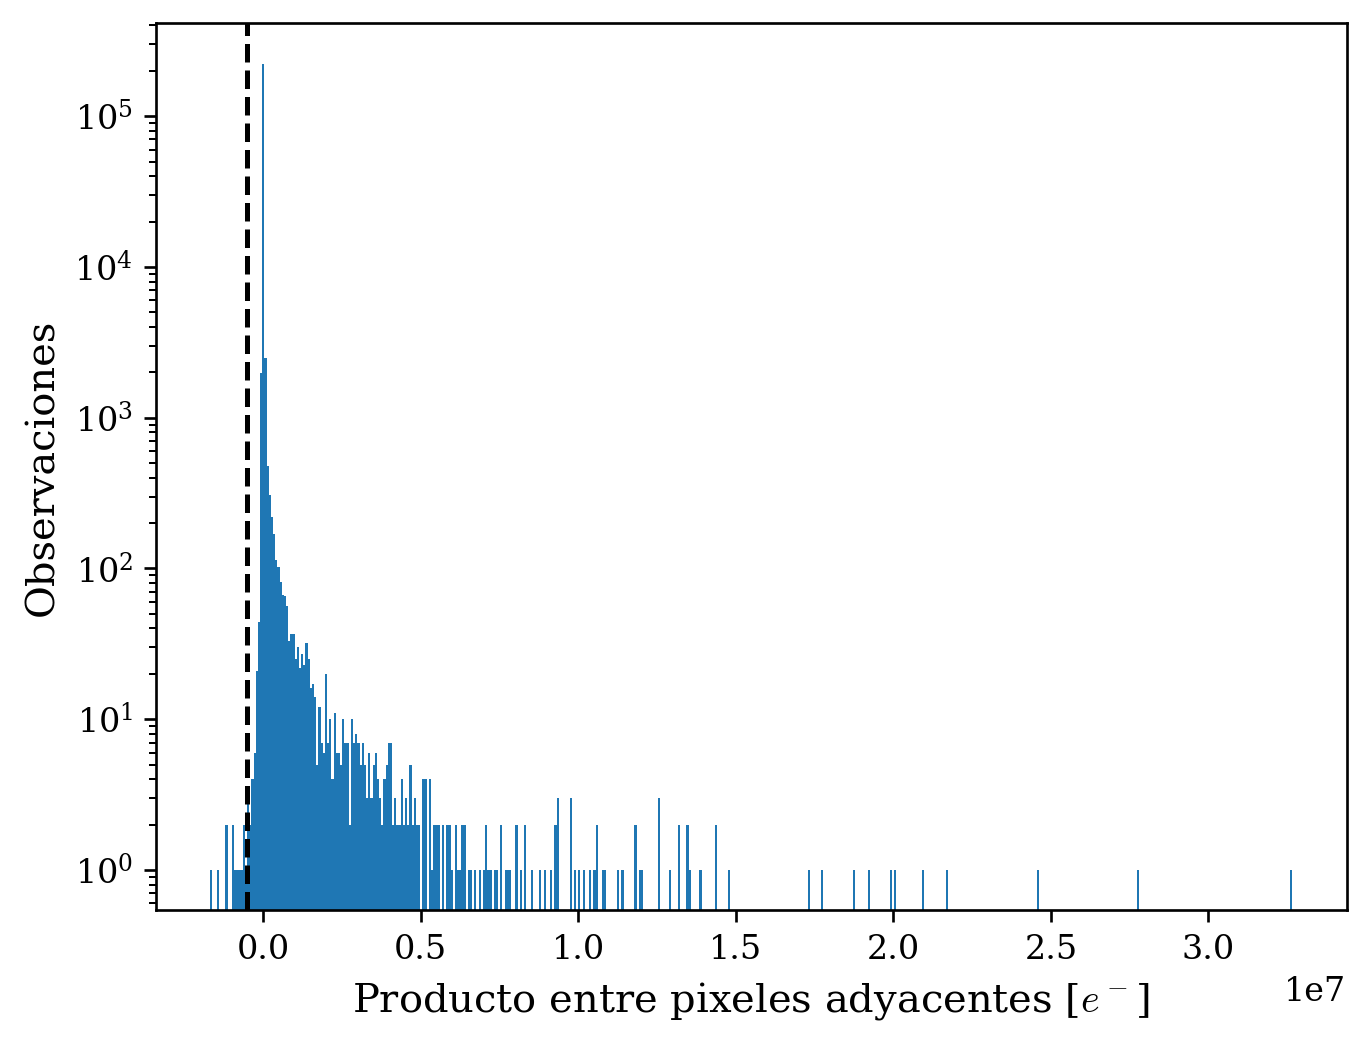

In [79]:
# EN PROGRESO...
plt.close("all")
%matplotlib inline
prod_arr = test_frame[:-1] * test_frame[1:]
plt.hist(prod_arr.flatten(), bins = 500)
#plt.xlim(xmax =0)
plt.yscale('log')
plt.axvline(x = -threshold, color='k', ls = '--')
plt.xlabel("Producto entre pixeles adyacentes [$e^-$]")
plt.ylabel("Observaciones")
#plt.ylim(ymax = 100)
plt.show()

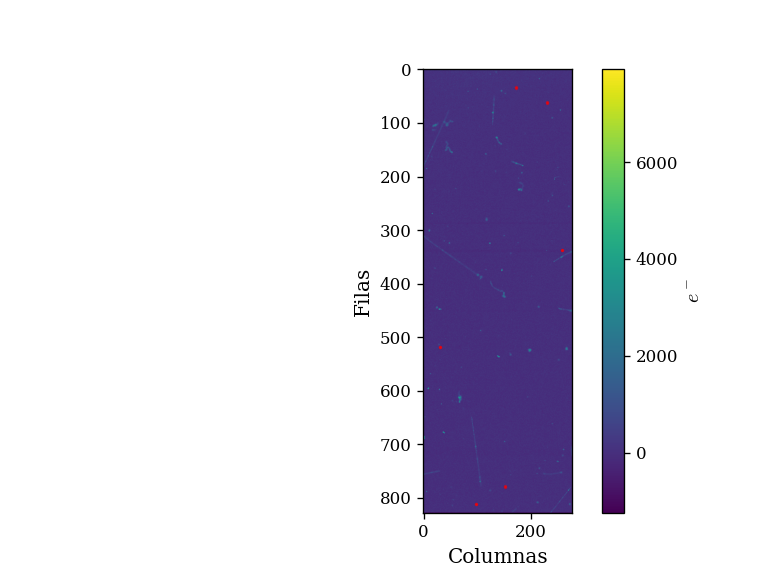

In [80]:
plt.close('all')
%matplotlib widget
fig, ax = plt.subplots(1, 1)
fig.set_label(f"Frame {frame_idx}")
mappable = ax.imshow(test_frame, cmap="viridis")
x_traps = []
y_traps = []
for coords in coordenadas_trampas:
    x_traps.append(coords[0][0])
    x_traps.append(coords[1][0])
    y_traps.append(coords[0][1])
    y_traps.append(coords[1][1])
plt.plot(y_traps, x_traps, '.r', ms=2, alpha=0.5)
ax.set_xlabel("Columnas")
ax.set_ylabel("Filas")
#ax.set_xlim(100, 150)
#ax.set_ylim(100, 150)
plt.colorbar(mappable, label=r"$e^-$", ax=ax)
plt.show()

In [3]:
# Cargar Archivos desde sus Carpetas por Temperatura
temperatura = 127
data_dir = CARPETAS_POR_TEMP[temperatura][-1]
files_in_dir = os.listdir(data_dir)
valid_formats = ["fits",]  # "fz"]
files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
file_data = [f"{i}    " + "    ".join(filename.split("_")[2:]) for i, filename in enumerate(files_in_dir)]
#print("Params in .fits Files in Directory:", *file_data, sep="\n")
frames_dict = dict()
coords_dict = dict()
vals_dict = dict()
prod_arr = dict()
mascara_dipolos = dict()
for file in tqdm(files_in_dir, desc="Procesando Archivos"):
    #print(file)
    dtph = int(file.rsplit("_")[5][4:])
    if dtph in coords_dict:
        continue
    #print(dtph)
    #i = -1
    test_image = fits.open(f'{data_dir}/{file}')
    frame_idx = 0
    frames_dict[dtph] = prepare_frame(test_image, frame_idx)  # e⁻
    threshold = 5e5
    corte_simetria = 20
    coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
        frames_dict[dtph], threshold, corte_simetria
    )

    #print(f"\nLoaded {files_in_dir[i]}\n")
#print(coords_dict)

Procesando Archivos:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
#plt.close('all')
#mascara_trampas_fijas = np.ones_like(test_frame, dtype=int)
#dtph_vals = list(coords_dict.keys())
#for dtph in dtph_vals:
#    mascara_trampas_fijas = mascara_trampas_fijas*mascara_dipolos[dtph]

#%matplotlib widget
#fig, ax = plt.subplots(1, 1)
#fig.set_label(f"Frame {frame_idx}")
#mappable = ax.imshow(mascara_trampas_fijas, cmap="viridis")

#ax.set_xlabel("Columnas")
#ax.set_ylabel("Filas")
#ax.set_xlim(100, 150)
#ax.set_ylim(100, 150)
#plt.colorbar(mappable, label=r"$e^-$", ax=ax)
#plt.show()

In [ ]:
"""Solo se queda con las trampas que pasan el threshold para todos los dtph
Está sesgado, porque las trampas solo se deberían ver bien para ciertos dtphs """
#trampas_consistentes = []
#intensidad_por_trampa = []
#dtph_vals = list(coords_dict.keys())
#print(dtph_vals)
#dtph_base = min(coords_dict.keys())
#for candidatos in tqdm(
#    coords_dict[dtph_base],
#    desc="Recorriendo Candidatos",
#    total=len(coords_dict[dtph_base]),
#                       ):
#    aparece = True
#    intensidades_candidato = [] 
#    for dtph in dtph_vals:
#        coords = coords_dict[dtph]
#        if candidatos in coords:
#            indice = coords.index(candidatos)
#            intensidades_candidato.append(vals_dict[dtph][indice])
#        else:
#            aparece = False
#            break
#    if aparece:
#        trampas_consistentes.append(candidatos)
#        intensidad_por_trampa.append(intensidades_candidato)


In [13]:
# frame_revisado = np.zeros_like(test_frame, dtype=int)
"""Identifica trampas en todos los dtph y busca la intensidad
 de cada trampa en todos los dtph"""
coords_medidas = set()
trampas_halladas = []
intensidad_por_trampa = []
dtph_vals = list(coords_dict.keys())
dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
for dtph in tqdm(
    dtph_vals[::-1],
    desc="Recorriendo dTph",
    total=len(dtph_vals),
):
    coordenadas_trampas = coords_dict[dtph]
    for coords in coordenadas_trampas:
        if coords in coords_medidas:
            continue
        trampas_halladas.append(coords)
        intensidades_trampa = []
        for dtph_frames in dtph_vals:
            frame = frames_dict[dtph_frames]
            intensidades_trampa.append(np.abs(frame[coords[0]]-frame[coords[1]])/2)
        intensidad_por_trampa.append(intensidades_trampa)
        coords_medidas.add(coords)
#print(coords_dict)

Recorriendo dTph:   0%|          | 0/18 [00:00<?, ?it/s]

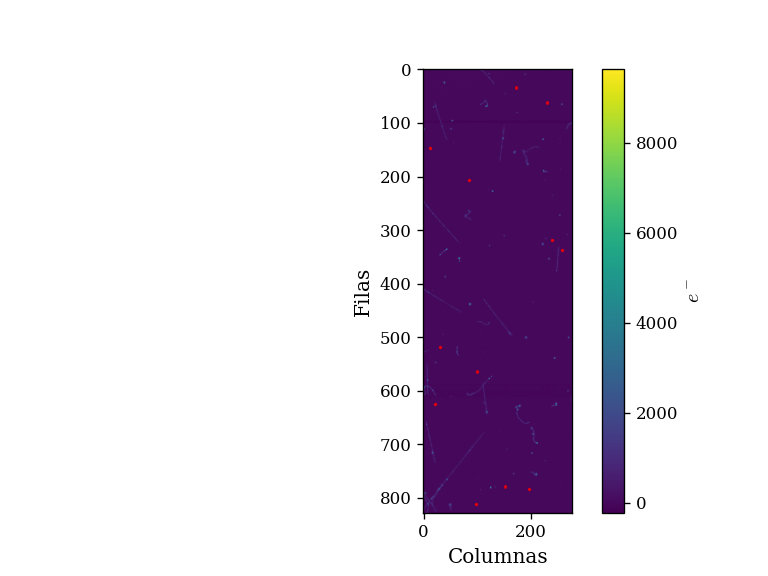

In [9]:
plt.close('all')
%matplotlib widget
fig, ax = plt.subplots(1, 1)
frame_idx = 0
fig.set_label(f"Frame {frame_idx}")
test_frame = prepare_frame(test_image, frame_idx)  # e⁻
mappable = ax.imshow(test_frame, cmap="viridis")
x_traps = []
y_traps = []
for coords in trampas_halladas:
    x_traps.append(coords[0][0])
    x_traps.append(coords[1][0])
    y_traps.append(coords[0][1])
    y_traps.append(coords[1][1])
plt.plot(y_traps, x_traps, '.r', ms=2, alpha=0.5)
ax.set_xlabel("Columnas")
ax.set_ylabel("Filas")
#ax.set_xlim(100, 150)
#ax.set_ylim(100, 150)
plt.colorbar(mappable, label=r"$e^-$", ax=ax)
plt.show()

12


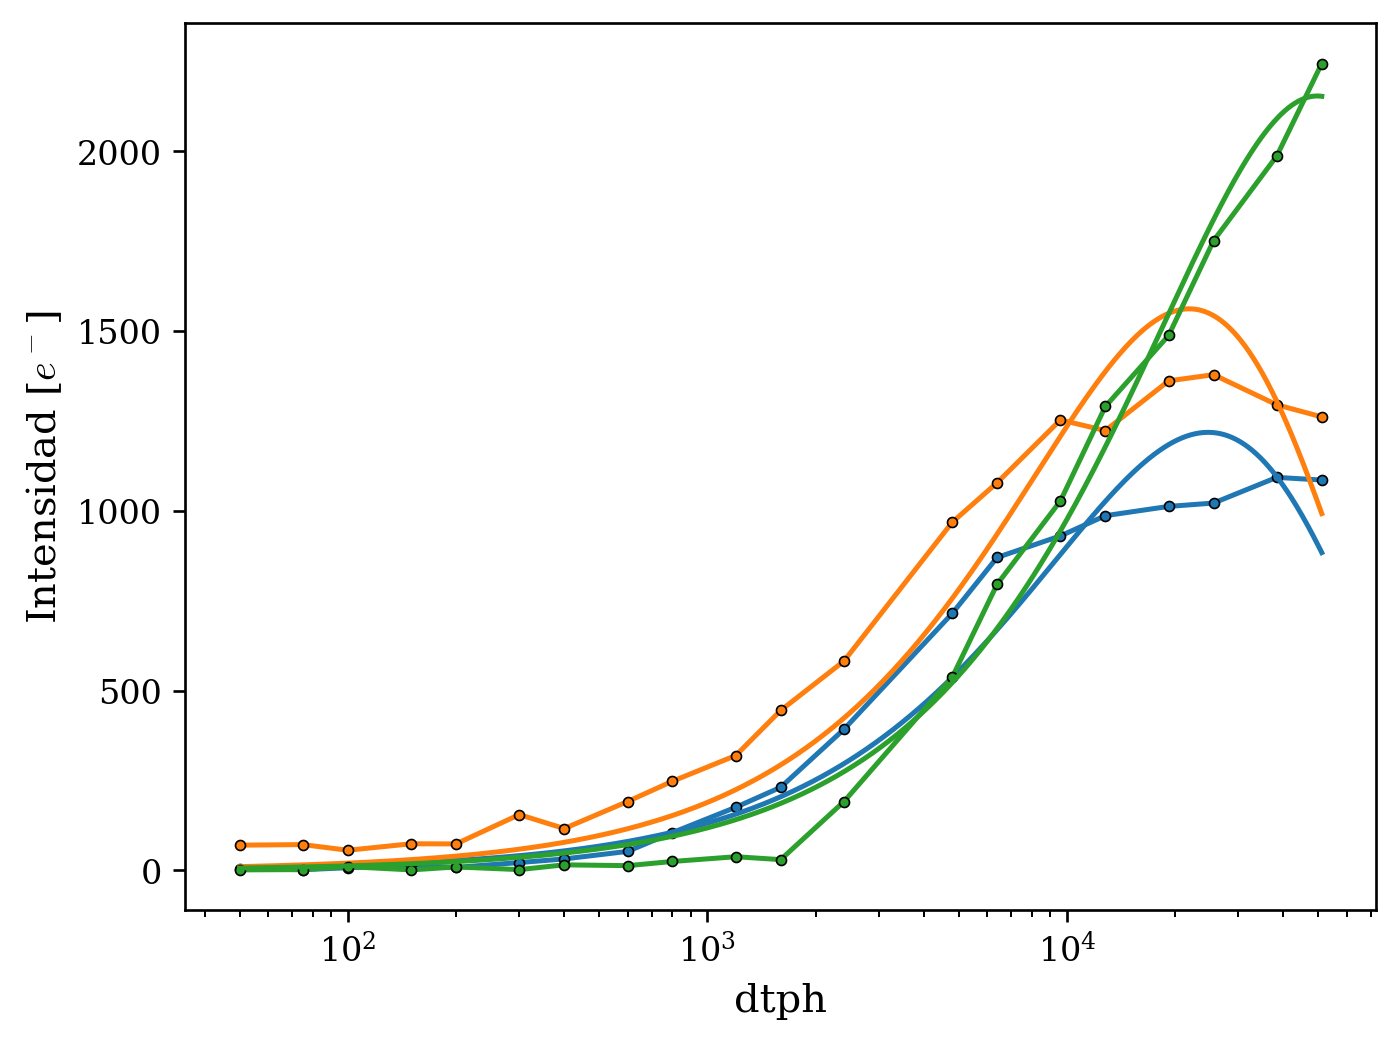

In [8]:

plt.close("all") 
def intensidad_func(tph, tau, Pc):
    return 40000*Pc*(np.exp(-tph/tau) - np.exp(-2*tph/tau))

%matplotlib inline
index = 4
print(len(intensidad_por_trampa))
for i, intensidades in enumerate(intensidad_por_trampa[index:index+3]):
    plt.plot(dtph_vals, intensidades , '.-', mec="k", mew=0.5, c=f"C{i%10}")
    popt, pcov = curve_fit(intensidad_func, dtph_vals, intensidades, p0=[1000, 1000])
    dtph_dense = np.geomspace(min(dtph_vals), max(dtph_vals), 1000)
    plt.plot(dtph_dense, intensidad_func(dtph_dense, *popt))
plt.xlabel("dtph")
plt.ylabel(r"Intensidad [$e^-$]")
plt.xscale("log")
plt.show()

In [ ]:
#dtph_dense = np.geomspace(50, 1600, 100)
#plt.plot(dtph_dense, intensidad_func(dtph_dense, 20, 0.9))
#plt.xscale("log")
#plt.show()

cuentas auxiliares

In [24]:
times_str = """\
50 -> 10 11 20, 10 16 40
100 -> 10 18 59, 10 24 19
200 -> 10 26 37, 10 31 58
400 -> 10 34 17, 10 39 38"""
parsed_times_str = [line.split(" -> ") for line in times_str.splitlines()]
dtphs = [parsed_strs[0] for parsed_strs in parsed_times_str]
times = [parsed_strs[1].split(", ") for parsed_strs in parsed_times_str]

In [31]:
starts_parsed = [time[0].split(" ") for time in times]
start_secs = [int(start[0])*3600 + int(start[1])*60 + int(start[2]) for start in starts_parsed]
ends_parsed = [time[1].split(" ") for time in times]
end_secs = [int(end[0])*3600 + int(end[1])*60 + int(end[2]) for end in ends_parsed]

durations = [end - start for start, end in zip(start_secs, end_secs)]
durations

[320, 320, 321, 321]

## Imágenes Santi

### Detección de dipolos

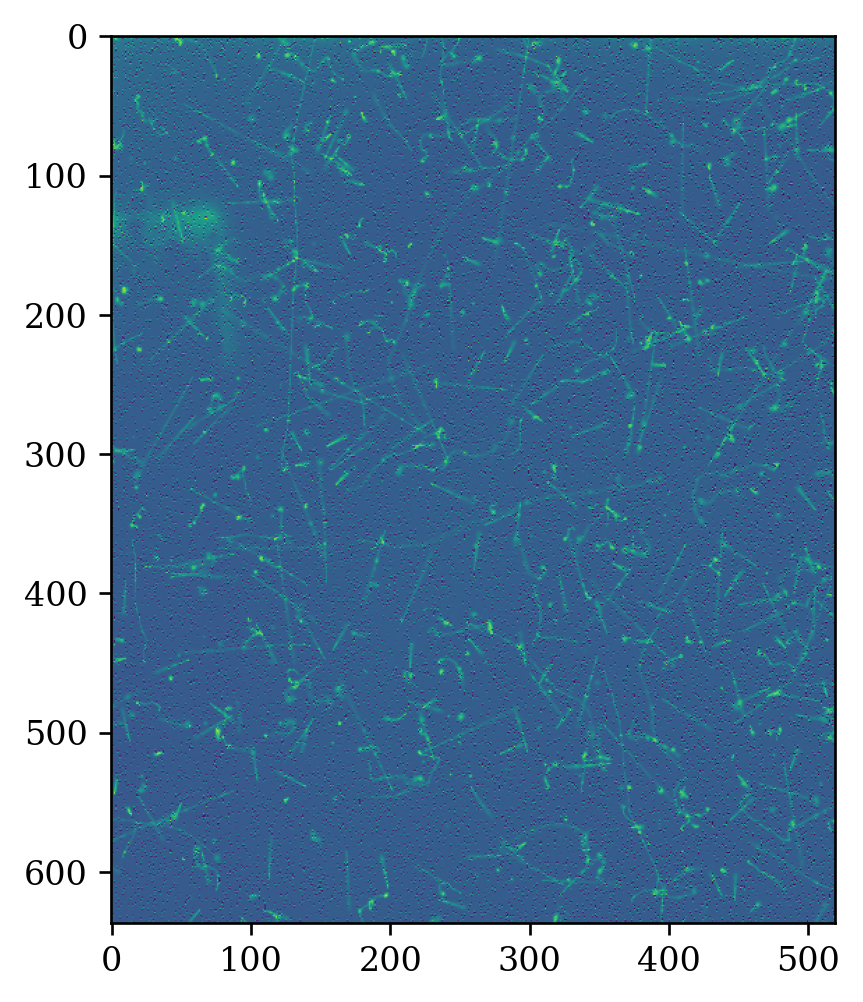

16934


In [ ]:
plt.close("all")
%matplotlib inline
data_dir = 'skipper_data\Imagenes_Santi'
t_ilum = 0.25
threshold = 0.7e11
#test_image = fits.open(f'{data_dir}\proc_skp_mod45_2ndbatch_T150_Vv2_seqrevOS_vdd-17_loopdtph_wledon140_npump40000_dtph100_NSAMP10_NROW650_NCOL650_EXPOSURE0_NBINROW1_NBINCOL1_img40.fits')
test_image = fits.open(f'{data_dir}\proc_skp_mod45_2ndbatch_T150_Vv2_seqrevOS_vdd-17_loopdtph_wledon140_npump40000_dtph2000000_NSAMP10_NROW650_NCOL650_EXPOSURE0_NBINROW1_NBINCOL1_img58.fits')
#test_image = correct_overscan(test_image)
test_frame = test_image[0].data
r_overscan, c_overscan = get_rowcol_ovserscan(test_image)
test_frame = test_frame[1:-r_overscan-1, PRESCAN_PIX+1:-c_overscan]
test_frame = test_frame-np.median(test_frame, axis=0)
dif_1 = np.diff(test_frame, axis=0, )
dif_2 = np.diff(test_frame[::-1], axis=0, )[::-1]
mascara_dipolos = np.zeros_like(dif_1, dtype=int)

prod_arr = test_frame[:-1] * test_frame[1:]
#prod_arr = dif_1 * dif_2
mascara_dipolos[prod_arr>=-threshold] = 0
mascara_dipolos[prod_arr<-threshold] = 1
coordenadas_trampas = []
for j, col in enumerate(prod_arr.T):
    for i, val in enumerate(col):
        if mascara_dipolos[i, j] == 1:
            if i == 0:
                i_lleno = np.argmax(test_frame[i:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i:i+2, j])
                i_vacio = i_vacio + i - 1
            elif i == len(col):
                i_lleno = np.argmax(test_frame[i-1:i+1, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+1, j])
                i_vacio = i_vacio + i - 1
            else:
                i_lleno = np.argmax(test_frame[i-1:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+2, j])
                i_vacio = i_vacio + i - 1
            if np.abs(i_lleno-i_vacio)==1:
               coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
#
# filtro_dipolos
#plt.imshow(np.log(np.abs(dif_1)+1))
plt.imshow(test_frame)
#plt.colorbar()

plt.show()

#plt.imshow(prod_arr)
#plt.colorbar()
#plt.show()
#plt.imshow(np.log(np.abs(mascara_dipolos)+1))
#plt.colorbar()
#plt.show()
#plt.imshow(np.log(np.abs(test_frame)+1))
#plt.imshow(test_frame)
#plt.colorbar()
#plt.show()
print(len(coordenadas_trampas))

Histograma para elegir el threshold

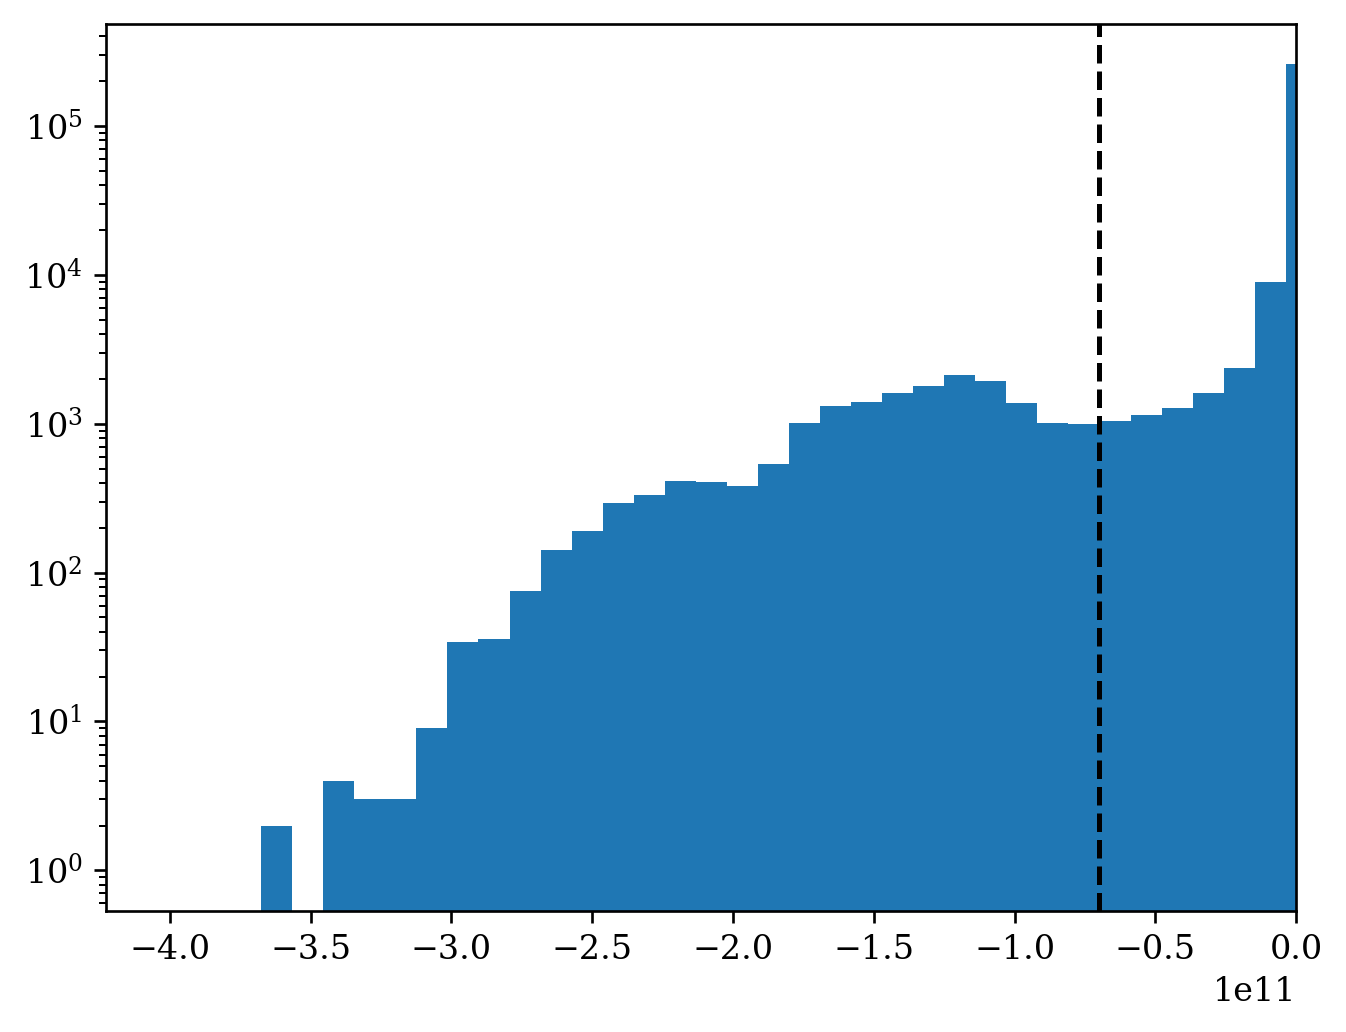

In [ ]:
plt.hist(prod_arr.flatten(), bins = 100)
plt.xlim(xmax = 0)
plt.yscale('log')
plt.axvline(x = -threshold, color='k', ls = '--')
#plt.ylim(ymax = 100)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12700\1358130242.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(colors)


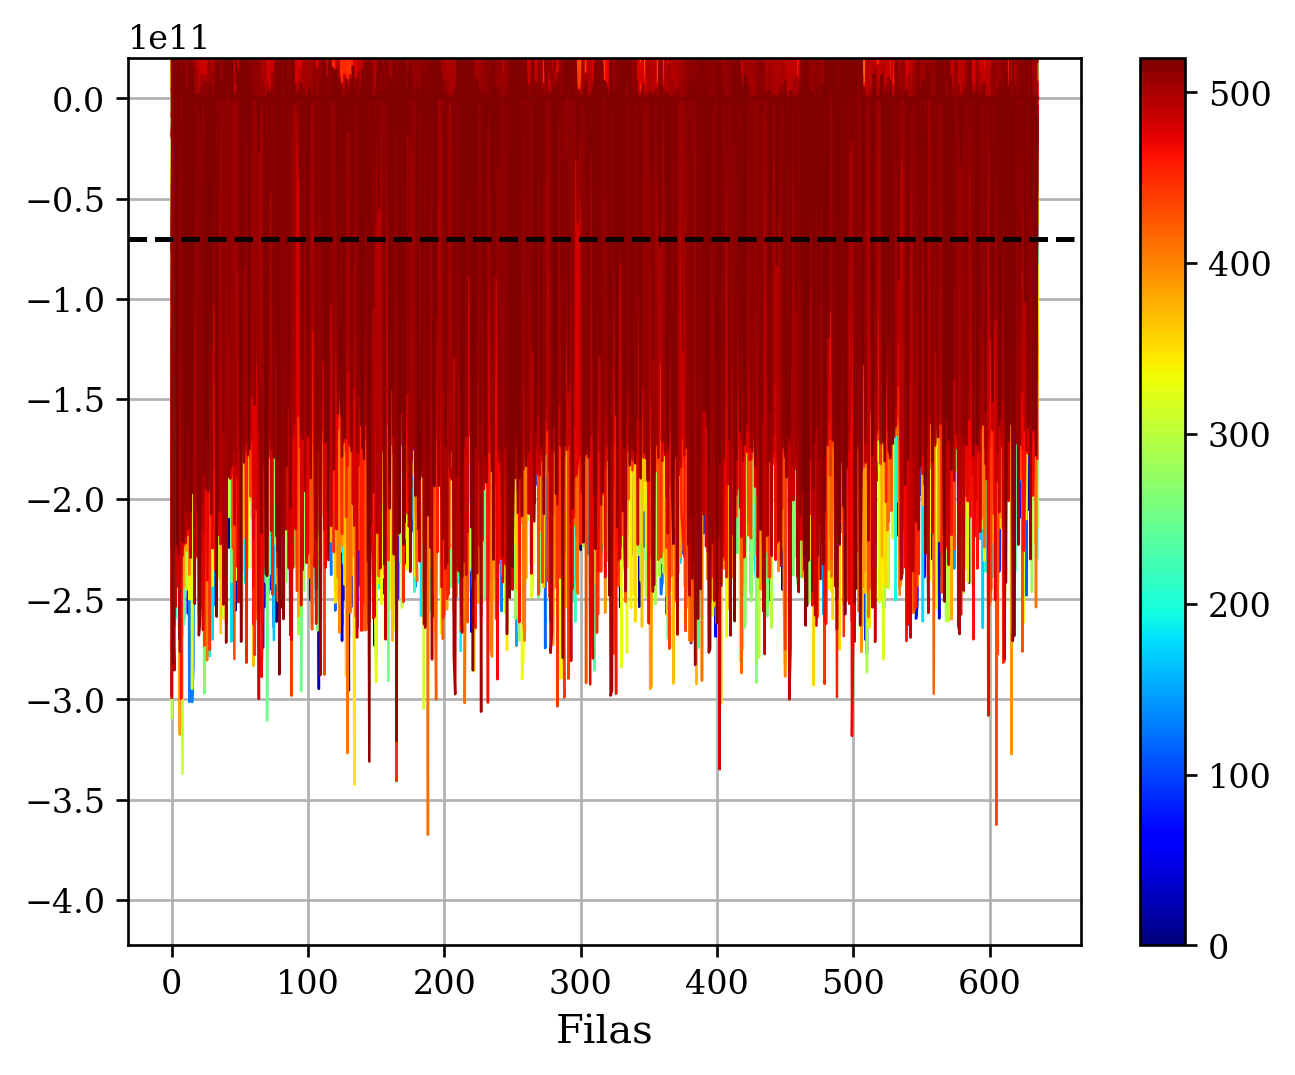

In [ ]:
plt.close('all')
%matplotlib inline
colors = plt.cm.ScalarMappable(norm=plt.Normalize(0, prod_arr.shape[1]),
                               cmap="jet")
for j, col in enumerate(prod_arr.T):
    #if j <100 : 
    #    plt.plot(col, color = 'k')
    #if j >= 100 and j < 200 : 
    #    plt.plot(col, color = 'b')
    #if j >=200 and j< 300: 
    #    plt.plot(col, color = 'g')
    #if j >= 300 and j < 400 : 
    #    plt.plot(col, color = 'm')
    #if j >= 400 and j < 500 : 
    #    plt.plot(col, color = 'r')
    #if j > 500:
    #    plt.plot(col, color = 'c') 
    plt.plot(col, lw=0.75, color=colors.to_rgba(j))
    
    #for i, val in enumerate(col):
    #    if val < -threshold:
    #        print(i, j)
#for col in dif_1.T:
#    plt.plot(col)
plt.xlabel("Filas")
#plt.axhline(threshold, xmin = 0, xmax = 828, ls = '--', color='k')
plt.axhline(-threshold, xmin = 0, xmax = 828, ls ='--', color = 'k')
plt.ylim(top= 0.2e11 )
plt.colorbar(colors)
plt.grid()
plt.show()
#for j, col in enumerate(test_frame.T):
#    if j <100 : 
#        plt.plot(col, color = 'k')
#    if j >= 100 and j < 200 : 
#        plt.plot(col, color = 'b')
#    if j >=200 and j< 300: 
#        plt.plot(col, color = 'g')
#    if j >= 300 and j < 400 : 
#        plt.plot(col, color = 'm')
#    if j >= 400 and j < 500 : 
#        plt.plot(col, color = 'r')
#    if j > 500:
#        plt.plot(col, color = 'c') 

#plt.xlabel("Filas")
#plt.show()

Filtro por simetría

In [ ]:
plt.close('all')
trampas_filtradas = []
corte_simetria = 80
for trampa in tqdm(coordenadas_trampas):
    fila_vals = [coord[0] for coord in trampa]
    col_vals = [coord[1] for coord in trampa]
    #print(fila_vals)
    val_1  = test_frame[fila_vals[0], col_vals[0]]
    val_2 = test_frame[fila_vals[1], col_vals[1]]
    diferencia_relativa = np.abs(100*(np.abs(val_1)-np.abs(val_2))/np.max([np.abs(val_1), np.abs(val_2)]))
    #print(diferencia_relativa)
    if diferencia_relativa < corte_simetria:
        trampas_filtradas.append(trampa)
print(len(coordenadas_trampas))
print(len(trampas_filtradas))

  0%|          | 0/16934 [00:00<?, ?it/s]

16934
16881


  0%|          | 0/16934 [00:00<?, ?it/s]

  0%|          | 0/16881 [00:00<?, ?it/s]

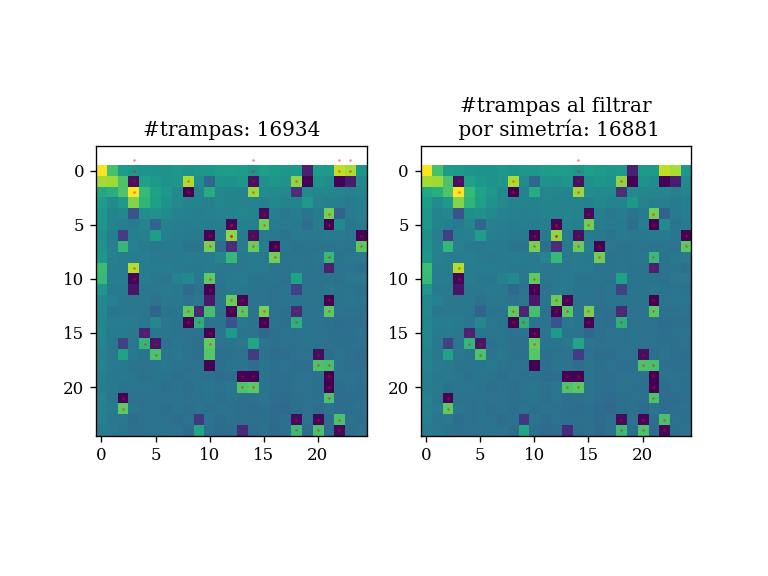

In [ ]:
from tqdm.notebook import tqdm
plt.close('all')
%matplotlib widget
fig, axs = plt.subplots(1, 2)
#fig, ax = plt.subplots(1, 1)
axs[0].imshow(test_frame[:25, :25])
#axs[0].imshow(test_frame)
axs[0].set_title(f'#trampas: {len(coordenadas_trampas)}')
for trampa in tqdm(coordenadas_trampas):
    fila_vals = [coord[0] for coord in trampa]
    col_vals = [coord[1] for coord in trampa]
    if max(col_vals)<25 and max(fila_vals)<25:
        axs[0].plot(col_vals, fila_vals, '.r', ms=1, alpha=0.5) 
axs[1].imshow(test_frame[:25, :25])
#axs[1].imshow(test_frame)
axs[1].set_title(f'#trampas al filtrar\n por simetría: {len(trampas_filtradas)}')
for trampa in tqdm(trampas_filtradas):
    fila_vals = [coord[0] for coord in trampa]
    col_vals = [coord[1] for coord in trampa]
    if max(col_vals)<25 and max(fila_vals)<25:
        axs[1].plot(col_vals, fila_vals, '.r', ms=1, alpha=0.5) 
#axs[1].imshow(mascara_dipolos)
plt.show()
if False:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 400:500])
    axs[1].imshow(mascara_dipolos[0:100, 400:500])
    plt.show()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 200:300])
    axs[1].imshow(mascara_dipolos[0:100, 200:300])
    plt.show()
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 200:300])
    axs[1].imshow(mascara_dipolos[0:100, 200:300])
    plt.show()

Eficiencia del algoritmo

In [ ]:
N_trampas = 50
print(f'Agrego {N_trampas} trampas ficticias')
coord_fake_traps = []
fake_traps = np.zeros_like(test_frame)
for i in range(N_trampas):
    x = int(np.random.rand(1,1)[0,0]*len(test_frame[:,0]))
    y = int(np.random.rand(1,1)[0,0]*len(test_frame[0,:]))
    #coord_fake_traps.append([x,y])
    fake_traps[x,y] = np.sqrt(2*threshold)
    fake_traps[x-1,y] = -np.sqrt(2*threshold)
    #print([x,y])
#plt.imshow(fake_traps)
mod_frame = test_frame + fake_traps

#busco las coordenadas de las trampas en la imagen original
dif_1 = np.diff(test_frame, axis=0, )
dif_2 = np.diff(test_frame[::-1], axis=0, )[::-1]
mascara_dipolos = np.zeros_like(dif_1, dtype=int)

prod_arr = test_frame[:-1] * test_frame[1:]
#prod_arr = dif_1 * dif_2
mascara_dipolos[prod_arr>=-threshold] = 0
mascara_dipolos[prod_arr<-threshold] = 1
coordenadas_trampas = []
for j, col in enumerate(prod_arr.T):
    for i, val in enumerate(col):
        if mascara_dipolos[i, j] == 1:
            if i == 0:
                i_lleno = np.argmax(test_frame[i:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i:i+2, j])
                i_vacio = i_vacio + i - 1
            elif i == len(col):
                i_lleno = np.argmax(test_frame[i-1:i+1, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+1, j])
                i_vacio = i_vacio + i - 1
            else:
                i_lleno = np.argmax(test_frame[i-1:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+2, j])
                i_vacio = i_vacio + i - 1
            if np.abs(i_lleno-i_vacio)==1:
               coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
print(f'La cantidad de trampas es {len(coordenadas_trampas)}')

#busco las coordenadas de las trampas en la imagen modificada
dif_1_fake = np.diff(mod_frame, axis=0, )
dif_2_fake = np.diff(mod_frame[::-1], axis=0, )[::-1]
mascara_dipolos_fake = np.zeros_like(dif_1_fake, dtype=int)

prod_arr_fake = mod_frame[:-1] * mod_frame[1:]
#prod_arr = dif_1 * dif_2
mascara_dipolos_fake[prod_arr_fake>=-threshold] = 0
mascara_dipolos_fake[prod_arr_fake<-threshold] = 1
coordenadas_trampas_fake = []
for j, col in enumerate(prod_arr_fake.T):
    for i, val in enumerate(col):
        if mascara_dipolos_fake[i, j] == 1:
            if i == 0:
                i_lleno = np.argmax(mod_frame[i:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(mod_frame[i:i+2, j])
                i_vacio = i_vacio + i - 1
            elif i == len(col):
                i_lleno = np.argmax(mod_frame[i-1:i+1, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(mod_frame[i-1:i+1, j])
                i_vacio = i_vacio + i - 1
            else:
                i_lleno = np.argmax(mod_frame[i-1:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(mod_frame[i-1:i+2, j])
                i_vacio = i_vacio + i - 1
            if np.abs(i_lleno-i_vacio)==1:
                coordenadas_trampas_fake.append(((i_lleno, j), (i_vacio, j)))

print(f'La cantidad de trampas es la imagen modificada es {len(coordenadas_trampas_fake)}')

print(f'La eficiencia es de {(len(coordenadas_trampas_fake)-len(coordenadas_trampas))/N_trampas *100}%')
#from tqdm.notebook import tqdm
#plt.close('all')
#%matplotlib widget
#fig, axs = plt.subplots(1, 2)
#fig, ax = plt.subplots(1, 1)
#ax.imshow(mod_frame)
#for trampa in tqdm(coordenadas_trampas_fake):
#    fila_vals = [coord[0] for coord in trampa]
#    col_vals = [coord[1] for coord in trampa]
#    ax.plot(col_vals, fila_vals, '.r', ms=1, alpha=0.5) 
#axs[1].imshow(mascara_dipolos)
#plt.show()



Agrego 50 trampas ficticias
La cantidad de trampas es 14
La cantidad de trampas es la imagen modificada es 61
La eficiencia es de 94.0%
